# Predicting Pediatric Appendicitis using Machine Learning

### Objectives
This project aims to predict three main outcomes for pediatric appendicitis patients:
1. **Diagnosis classification**: Appendicitis vs. no appendicitis.
2. **Severity classification**: With or without complications.
3. **Management**: Surgical vs. conservative.

### Performance Metrics
For evaluating the models, the following performance metrics will be used:
1. **Accuracy**: The percentage of correctly classified instances.
2. **Precision**: The ability of the model to return relevant results.
3. **Recall**: The ability to identify relevant results.
4. **F1 Score**: The harmonic mean of precision and recall.
5. **AUC-ROC Curve**: The Area Under the Receiver Operating Characteristic Curve.

---


## Data Preparation

In [90]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import skew

# Load dataset
data = pd.read_csv('/Users/rasaki/Downloads/Appendicitis Project Assets/appendicitis_data.csv')
data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,12.68,16.9,female,148.0,37.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.10,31.9,male,147.0,69.5,2.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.14,23.3,female,163.0,62.0,4.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.37,20.6,female,165.0,56.0,3.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.08,16.9,female,163.0,45.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,12.68,16.9,female,148.0,37.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.10,31.9,male,147.0,69.5,2.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.14,23.3,female,163.0,62.0,4.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.37,20.6,female,165.0,56.0,3.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.08,16.9,female,163.0,45.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-Test Split for Three Models
Before handling missing data, we split the dataset into features (X) and target variables (y) for each of the three classification models: **Diagnosis**, **Severity**, and **Management**. The features consist of all variables excluding the target columns, and separate train-test splits are performed for each model to ensure independent model evaluation. The `train_test_split` function splits the data, with 80% used for training and 20% for testing.

In [92]:
# Merging 'primary surgical' and 'secondary surgical' into 'surgical' in the Management column
data['Management'] = data['Management'].replace({'primary surgical': 'surgical', 'secondary surgical': 'surgical'})

# Splitting the dataset into features and target for each model
X = data.drop(columns=['Diagnosis', 'Severity', 'Management'])

# Diagnosis model
y_diagnosis = data['Diagnosis']
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_diagnosis, test_size=0.2, random_state=42)

# Severity model
y_severity = data['Severity']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_severity, test_size=0.2, random_state=42)

# Management model
y_management = data['Management']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y_management, test_size=0.2, random_state=42)
    

### Data Preprocessing: Handling Missing Values and Encoding

In this step, we:

1. **Drop Columns with >50% Missing Data:** To remove features with excessive missing values.
2. **Impute Missing Values:** Use mean imputation for numerical features and the most frequent category for categorical features.
3. **Apply Imputation to Test Data:** Ensure consistent transformation on both training and test sets.
4. **Encode Categorical Variables:** Perform one-hot encoding on categorical features in both training and test sets.
5. **Reindex Test Data:** Ensure test datasets have the same columns as the training sets by reindexing and filling missing columns with 0.

In [95]:
# Dropping columns with more than 50% missing values
threshold = 0.5
X_train_d = X_train_d.loc[:, X_train_d.isnull().mean() < threshold]
X_train_s = X_train_s.loc[:, X_train_s.isnull().mean() < threshold]
X_train_m = X_train_m.loc[:, X_train_m.isnull().mean() < threshold]

# Imputing and encoding training data
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Separate numerical and categorical columns
num_cols = X_train_d.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train_d.select_dtypes(include=['object']).columns

# Impute missing values for train data
X_train_d[num_cols] = imputer_num.fit_transform(X_train_d[num_cols])
X_train_s[num_cols] = imputer_num.transform(X_train_s[num_cols])
X_train_m[num_cols] = imputer_num.transform(X_train_m[num_cols])

X_train_d[cat_cols] = imputer_cat.fit_transform(X_train_d[cat_cols])
X_train_s[cat_cols] = imputer_cat.transform(X_train_s[cat_cols])
X_train_m[cat_cols] = imputer_cat.transform(X_train_m[cat_cols])

# Apply the same transformations to test data (after dropping columns with >50% missing values)
X_test_d = X_test_d[X_train_d.columns]
X_test_s = X_test_s[X_train_s.columns]
X_test_m = X_test_m[X_train_m.columns]

X_test_d[num_cols] = imputer_num.transform(X_test_d[num_cols])
X_test_s[num_cols] = imputer_num.transform(X_test_s[num_cols])
X_test_m[num_cols] = imputer_num.transform(X_test_m[num_cols])

X_test_d[cat_cols] = imputer_cat.transform(X_test_d[cat_cols])
X_test_s[cat_cols] = imputer_cat.transform(X_test_s[cat_cols])
X_test_m[cat_cols] = imputer_cat.transform(X_test_m[cat_cols])

# Encoding categorical variables for all data
X_train_encoded_d = pd.get_dummies(X_train_d, drop_first=True)
X_train_encoded_s = pd.get_dummies(X_train_s, drop_first=True)
X_train_encoded_m = pd.get_dummies(X_train_m, drop_first=True)

X_test_encoded_d = pd.get_dummies(X_test_d, drop_first=True)
X_test_encoded_s = pd.get_dummies(X_test_s, drop_first=True)
X_test_encoded_m = pd.get_dummies(X_test_m, drop_first=True)

# Ensure that test datasets have the same columns as train datasets
X_test_encoded_d = X_test_encoded_d.reindex(columns=X_train_encoded_d.columns, fill_value=0)
X_test_encoded_s = X_test_encoded_s.reindex(columns=X_train_encoded_s.columns, fill_value=0)
X_test_encoded_m = X_test_encoded_m.reindex(columns=X_train_encoded_m.columns, fill_value=0)

## Exploratory Data Analysis (EDA)

Next, we conduct EDA for the **Diagnosis**, **Severity**, and **Management** models to gain insights into the relationships between features and the target variables. Here's what we do for each model:

1. **Numeric Feature Distribution:**
   - Histograms are plotted to visualize the distribution of numeric features for each model.

2. **Correlation Heatmap:**
   - A heatmap is generated to show correlations between numeric features, helping identify highly correlated variables.

3. **Categorical Feature Analysis:**
   - Box plots are used to explore the relationship between categorical features and the target variable (Diagnosis, Severity, or Management).

This analysis helps us understand the structure of the data and guide feature selection for each model.

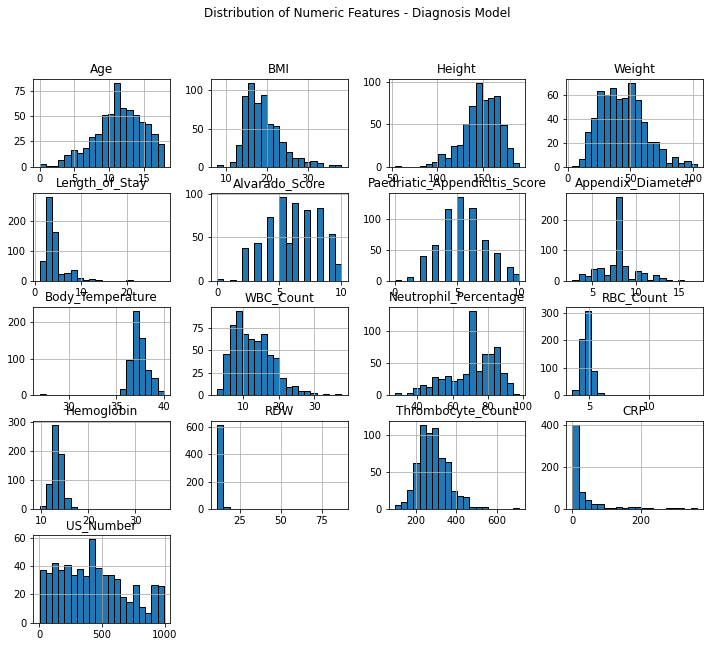

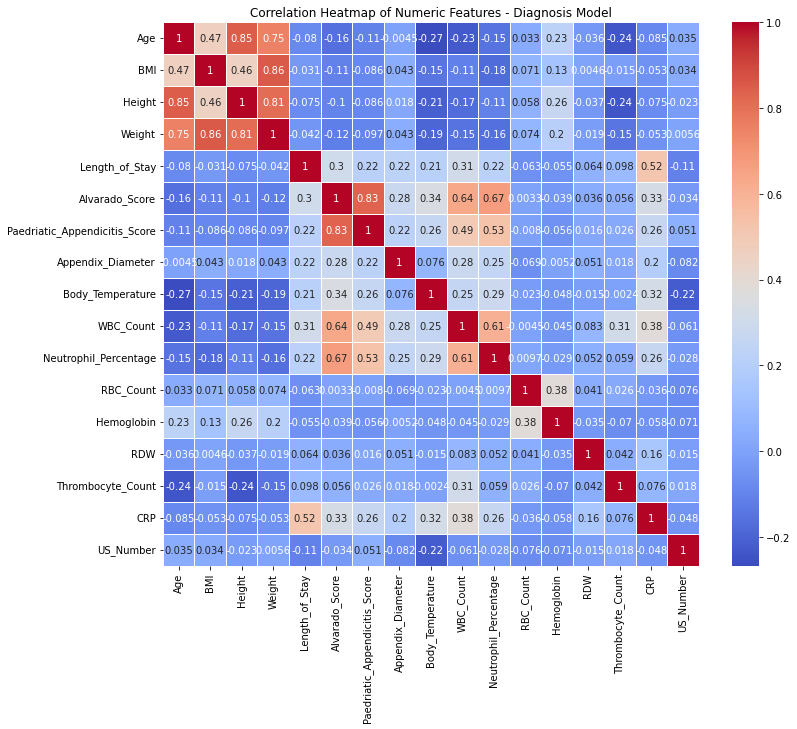

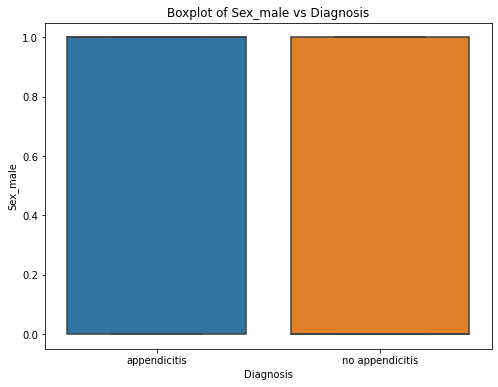

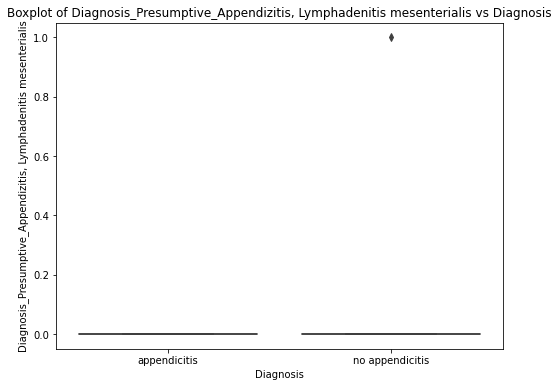

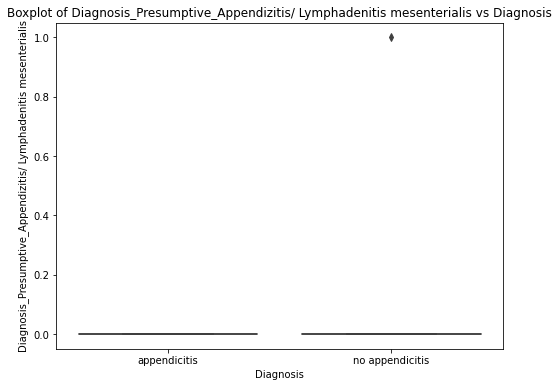

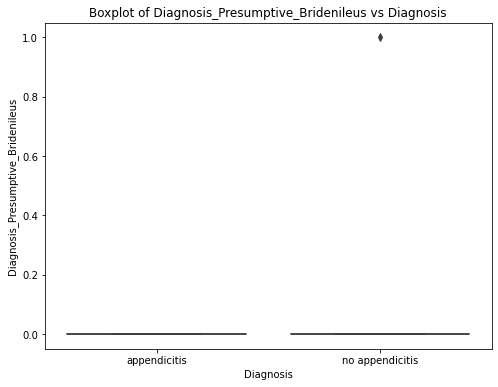

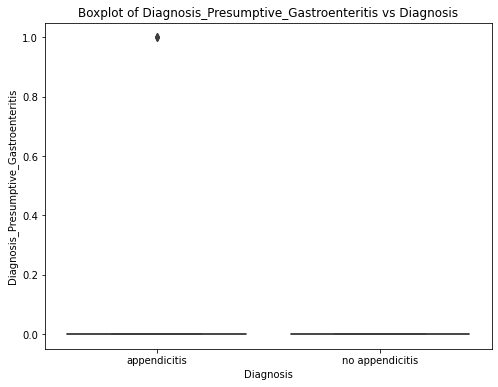

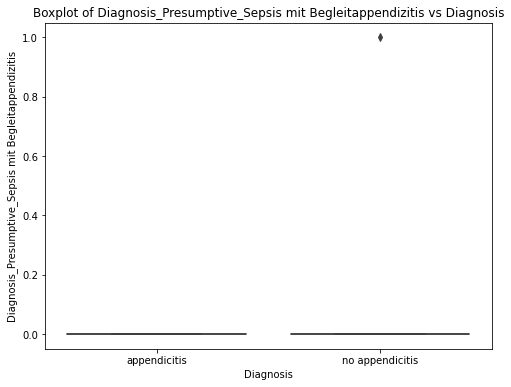

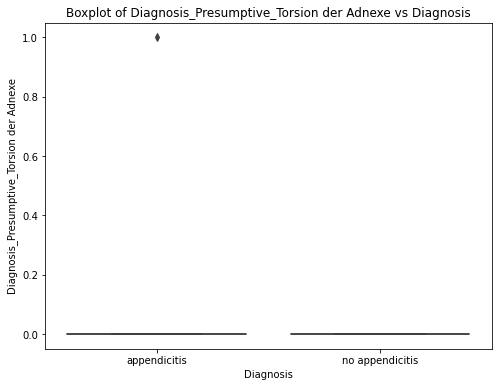

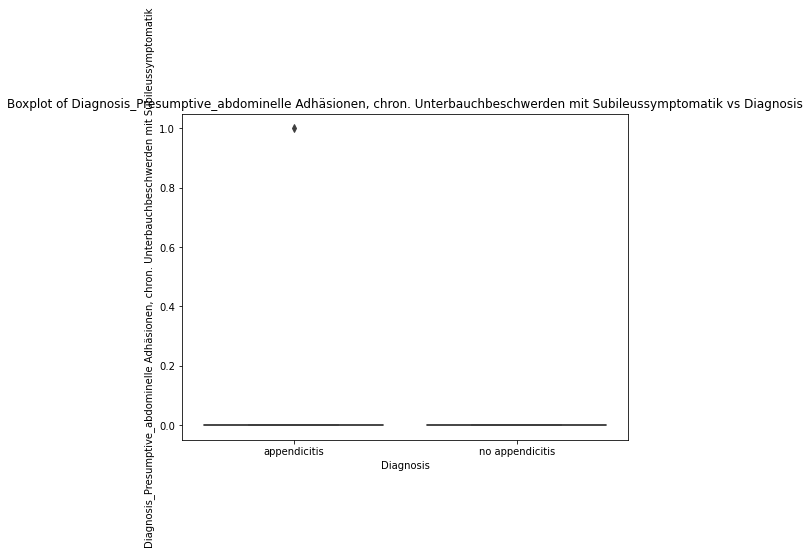

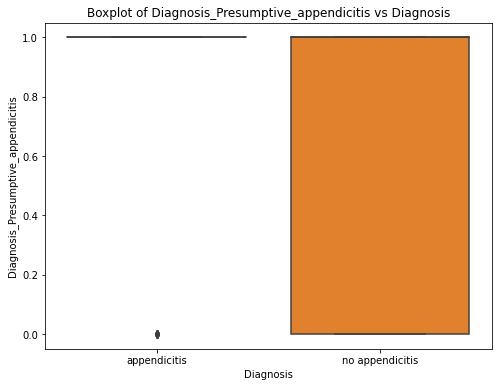

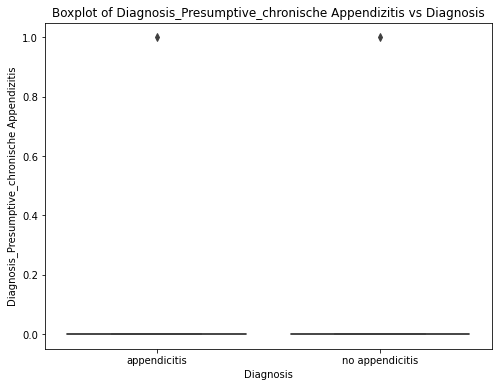

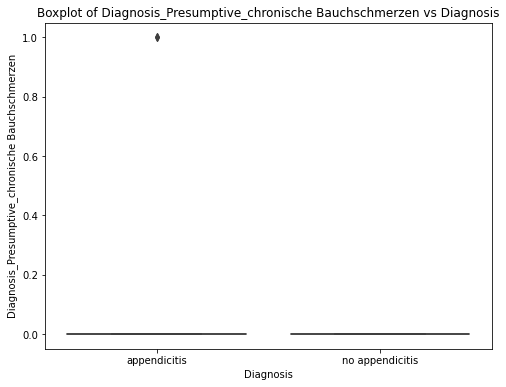

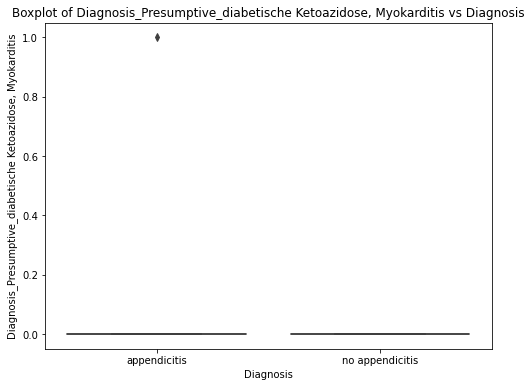

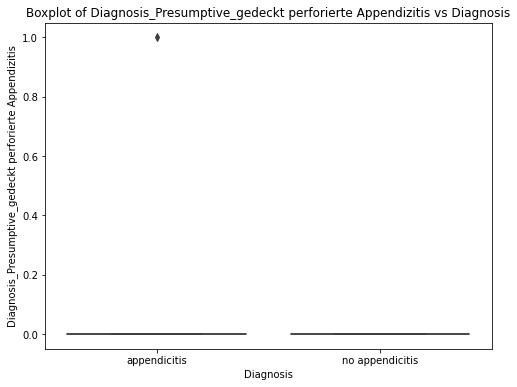

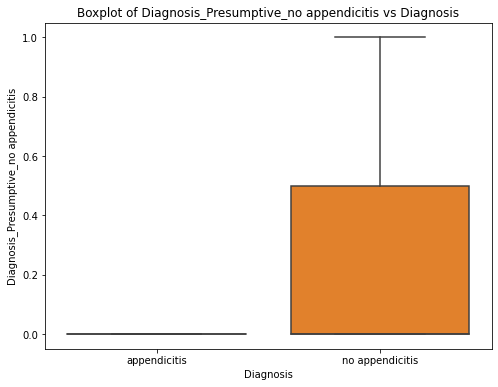

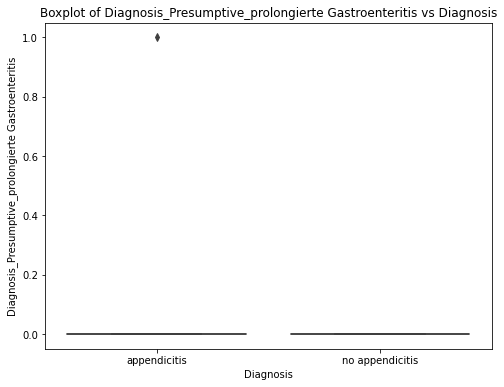

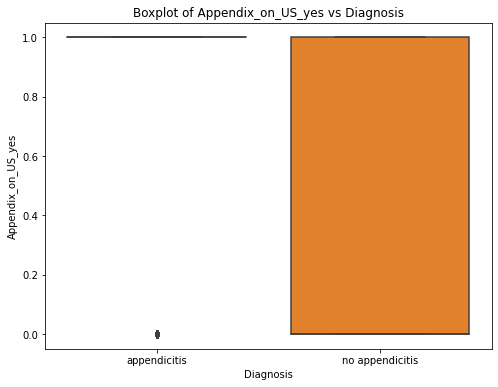

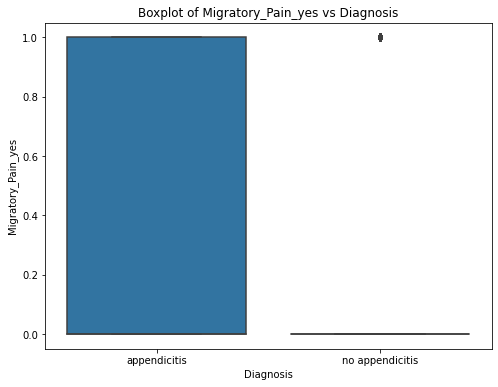

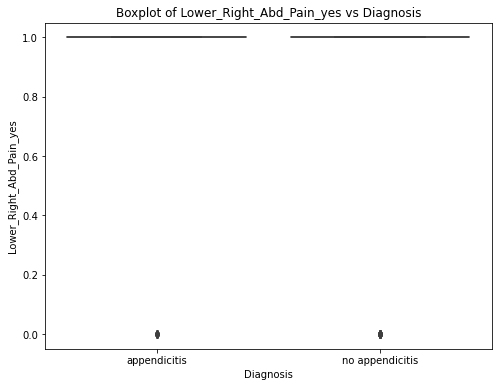

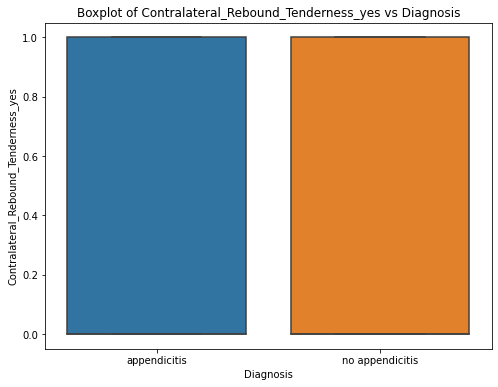

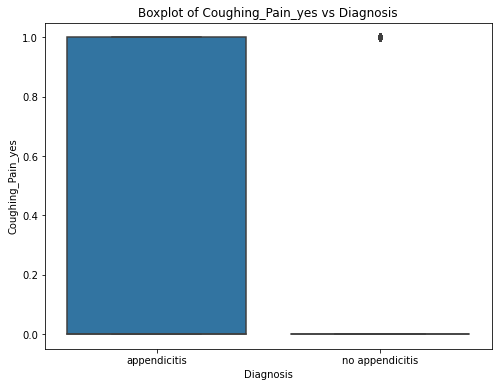

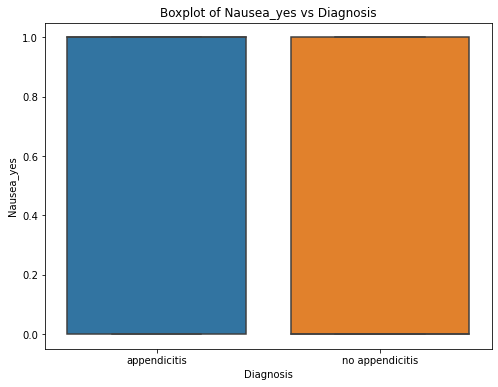

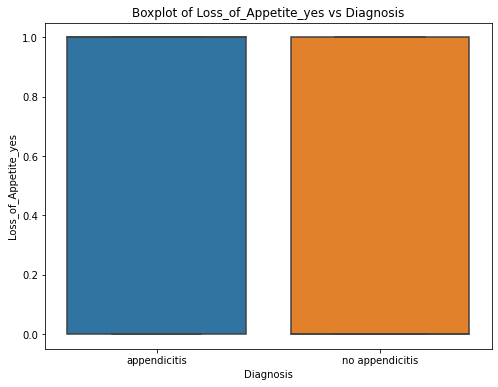

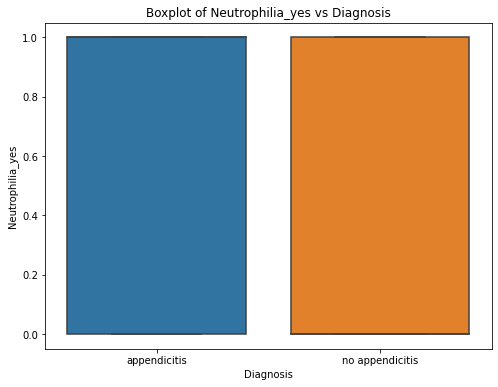

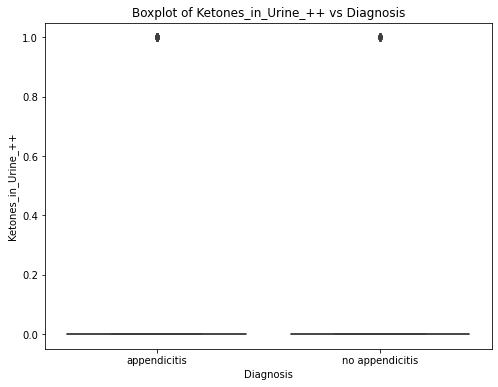

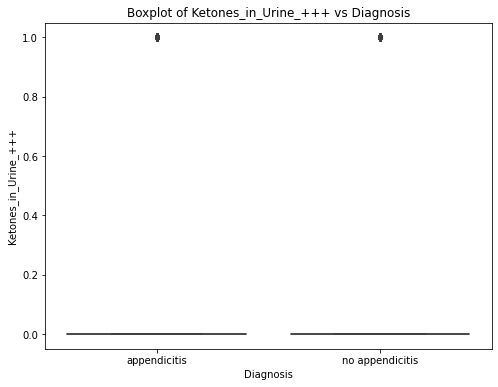

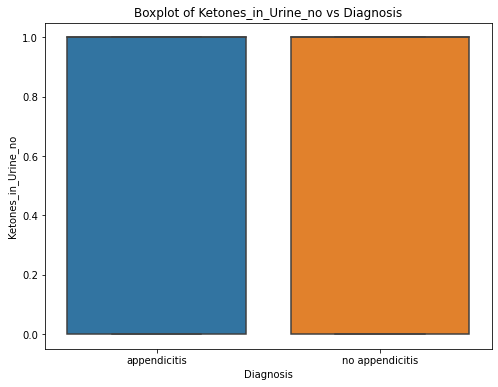

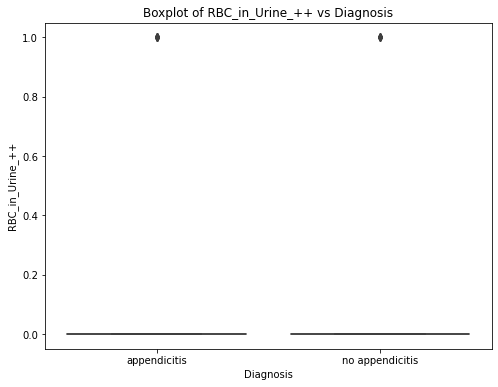

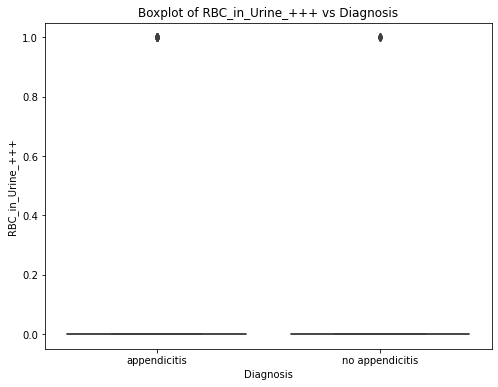

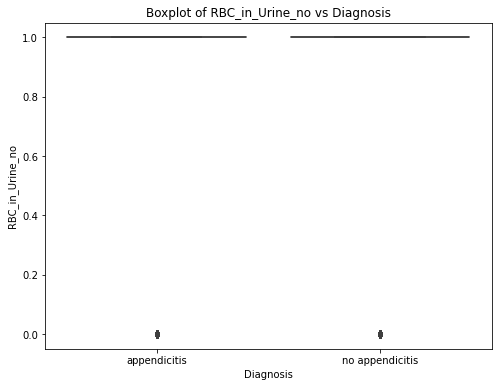

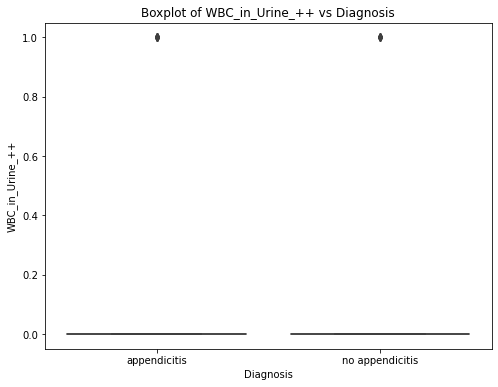

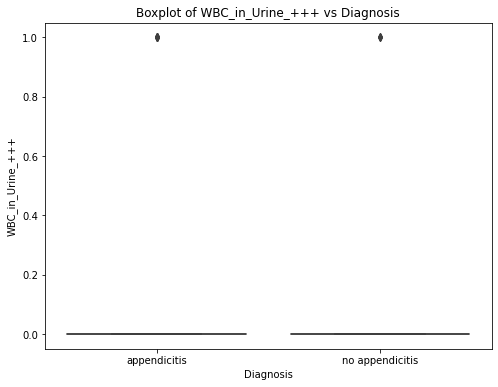

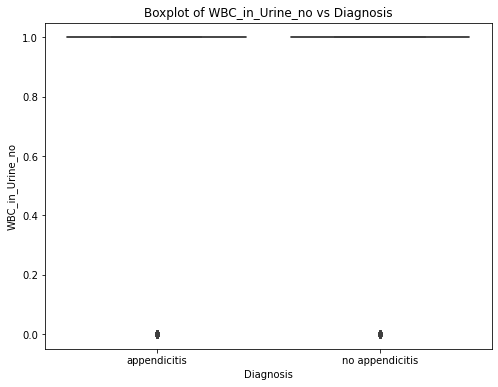

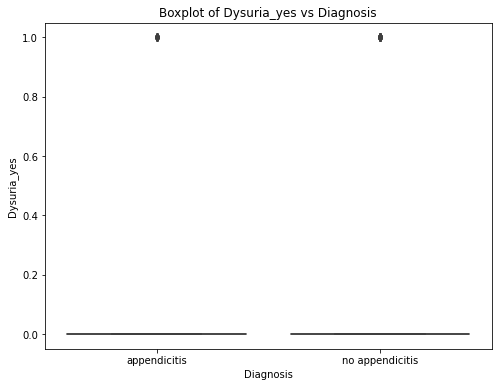

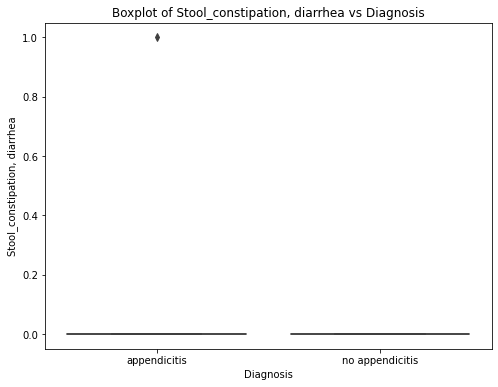

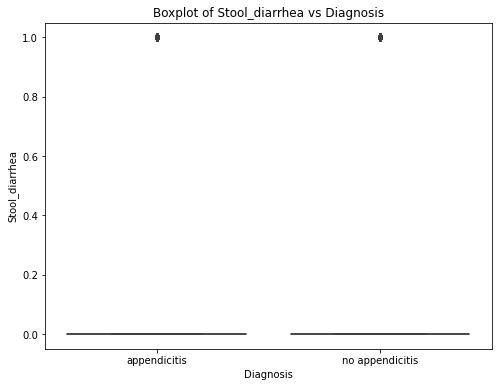

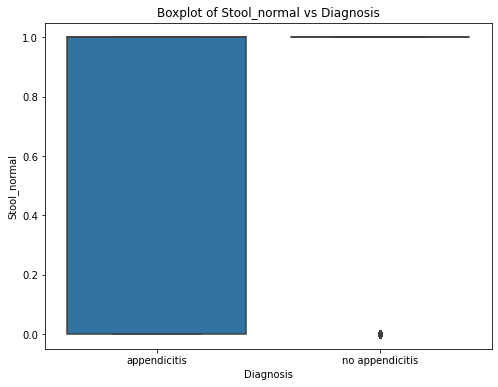

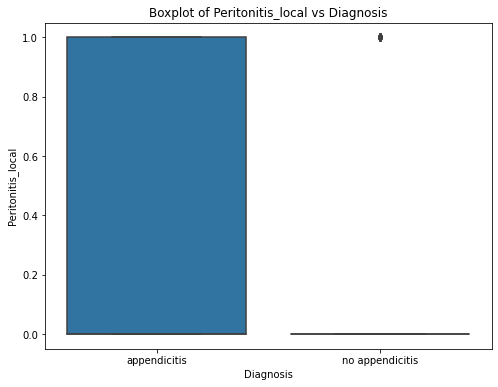

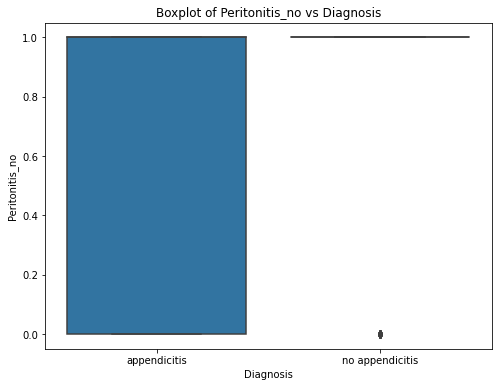

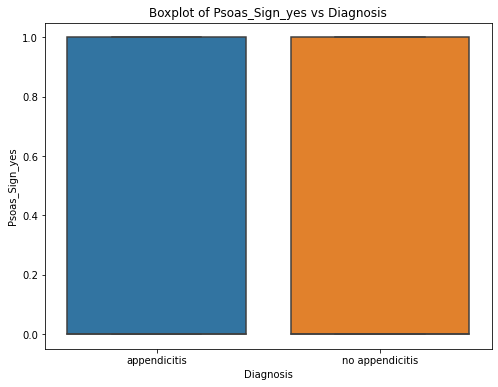

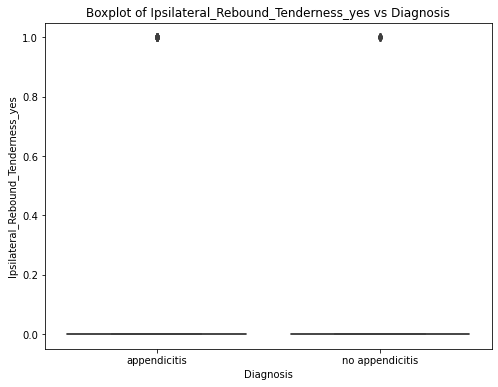

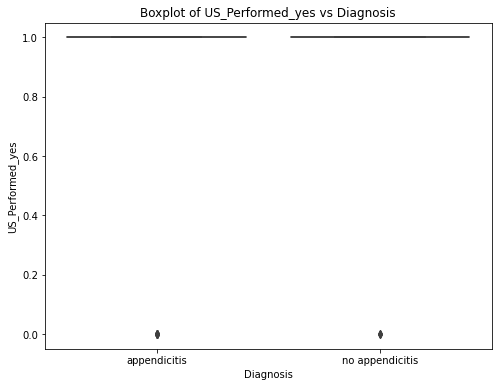

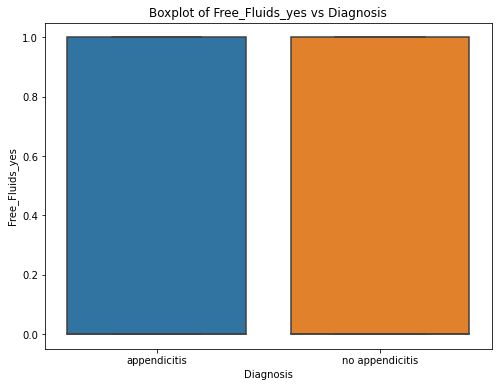

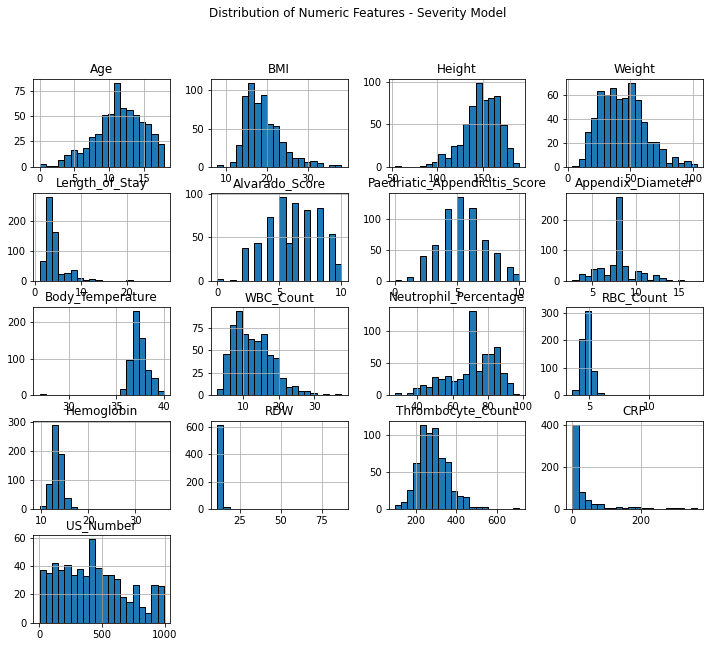

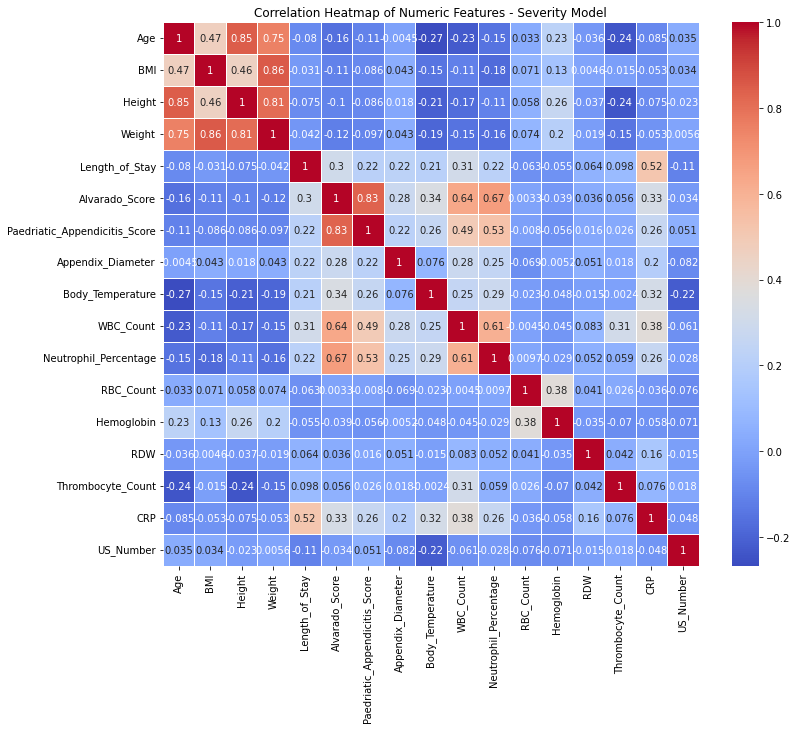

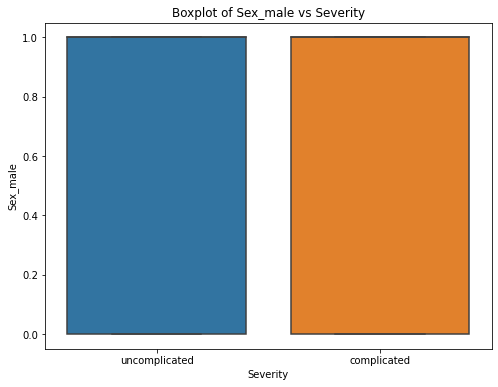

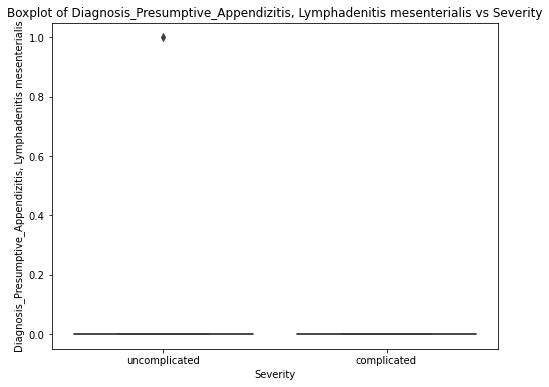

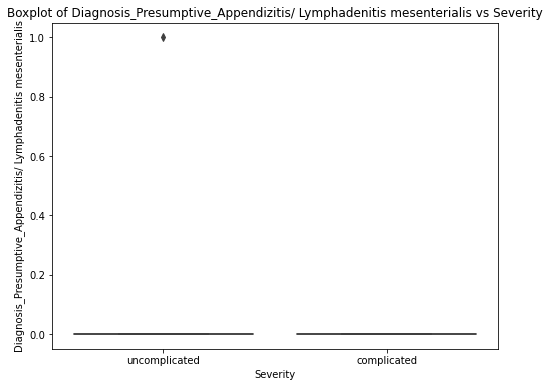

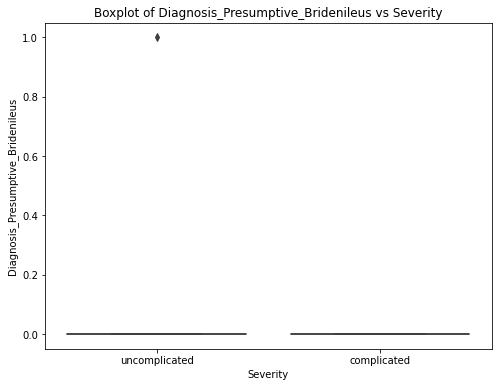

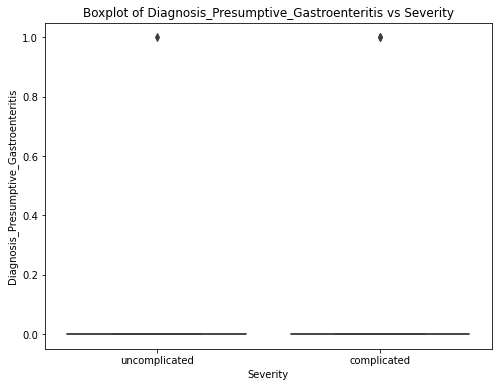

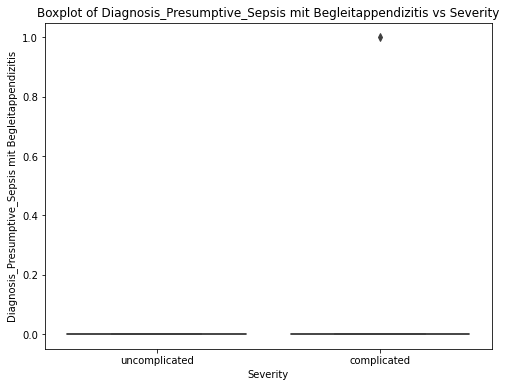

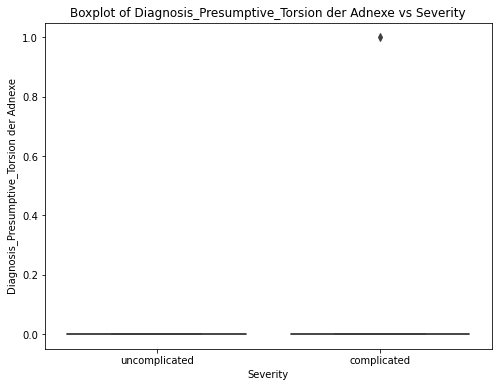

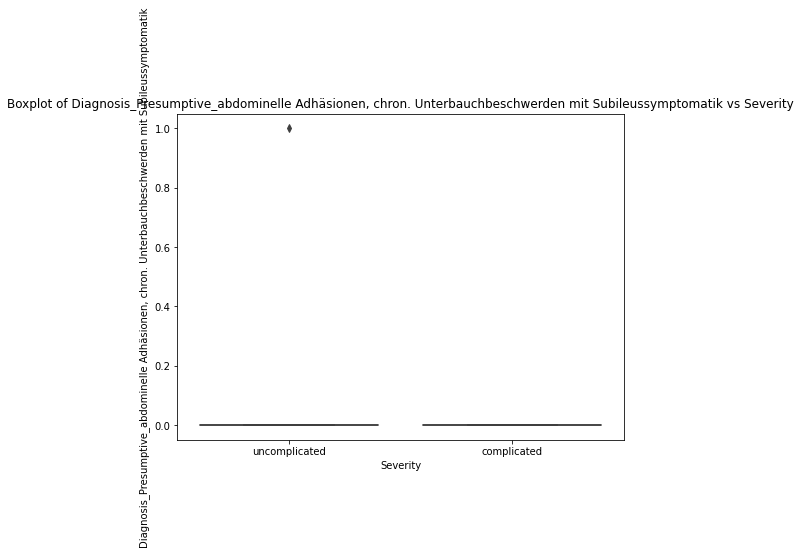

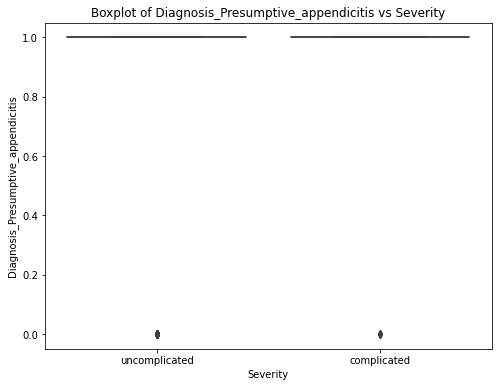

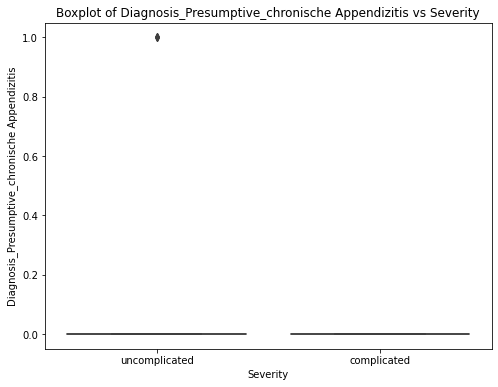

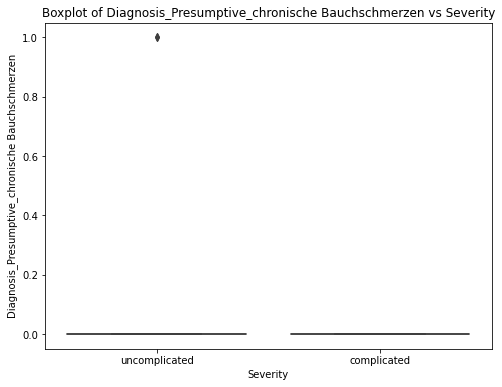

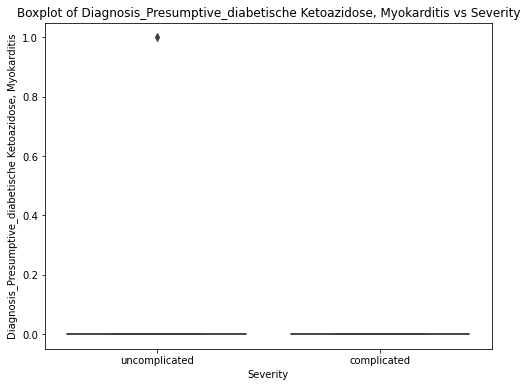

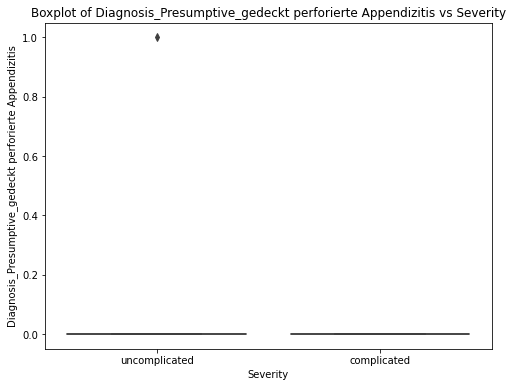

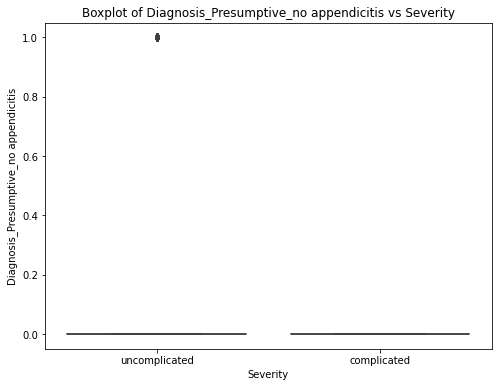

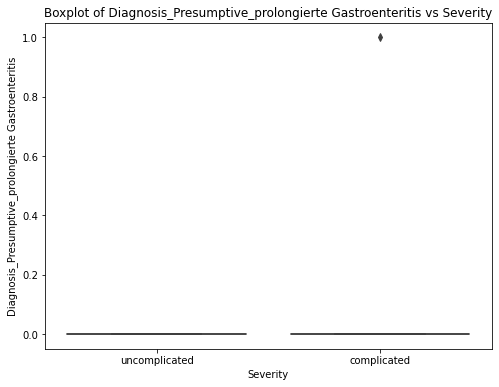

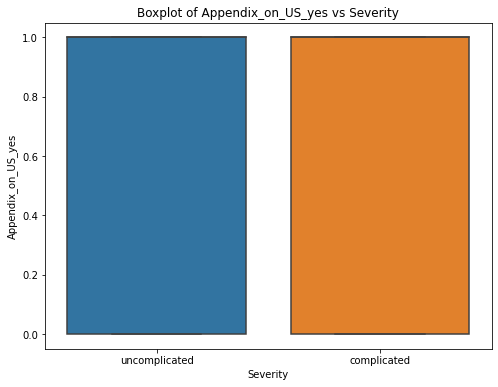

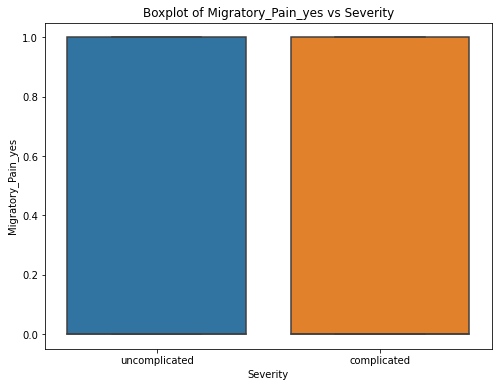

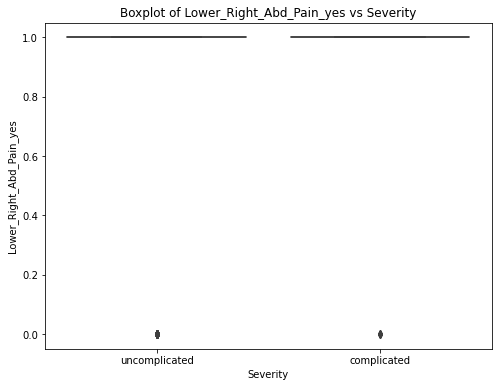

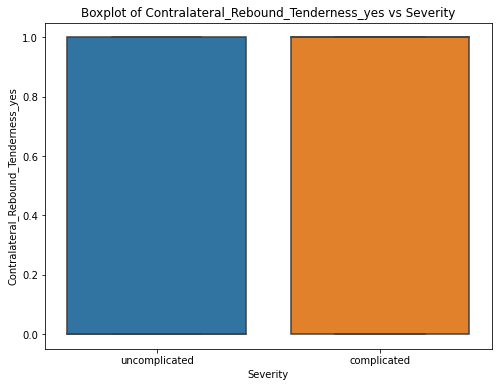

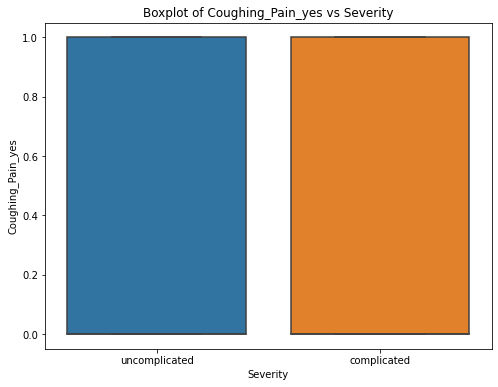

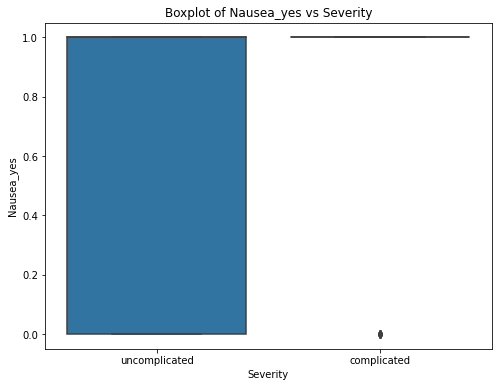

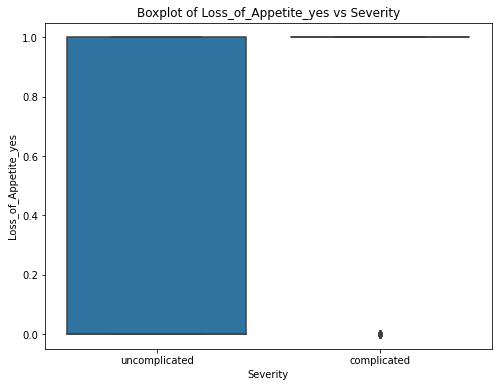

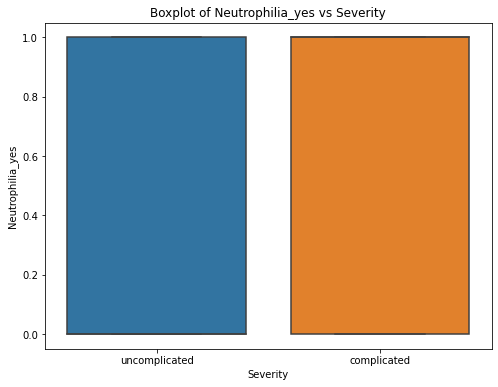

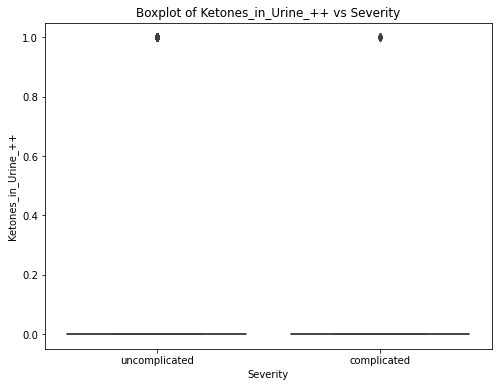

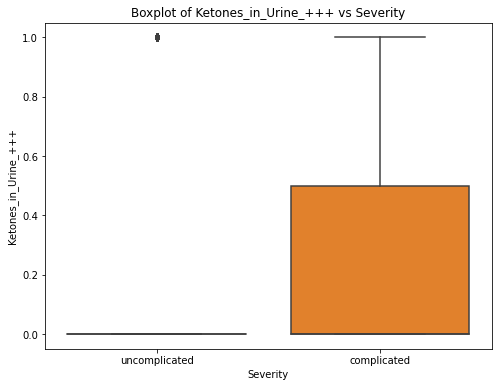

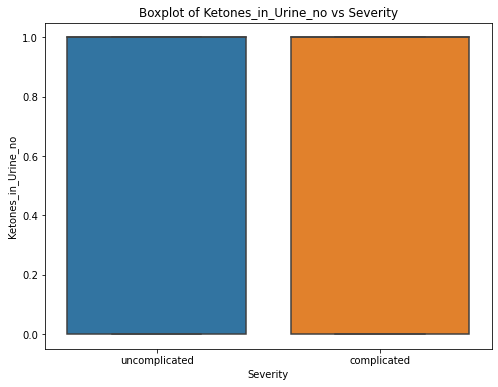

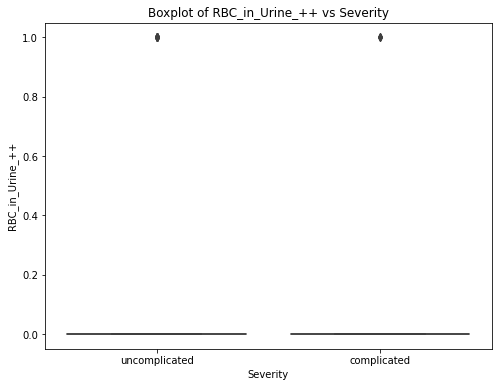

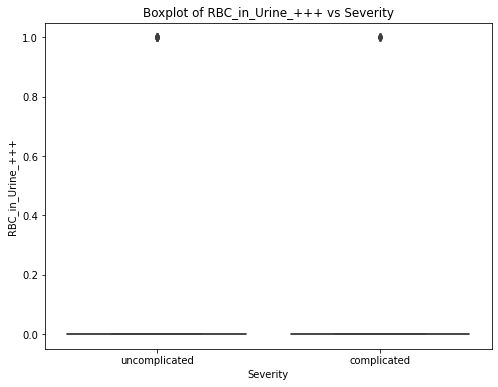

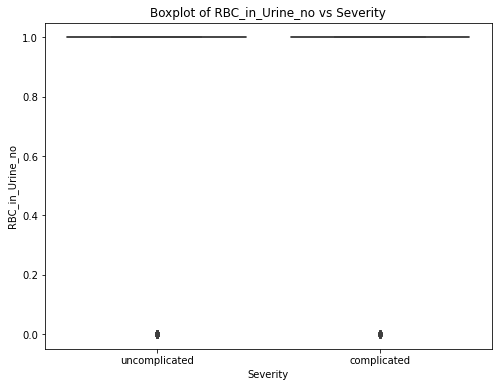

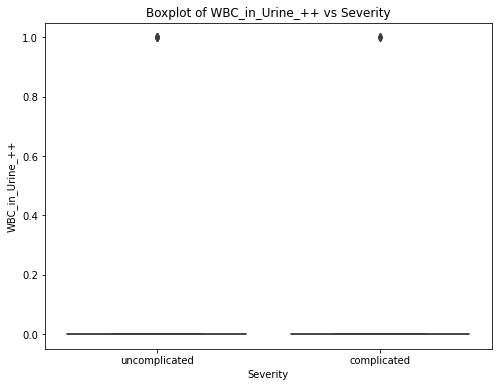

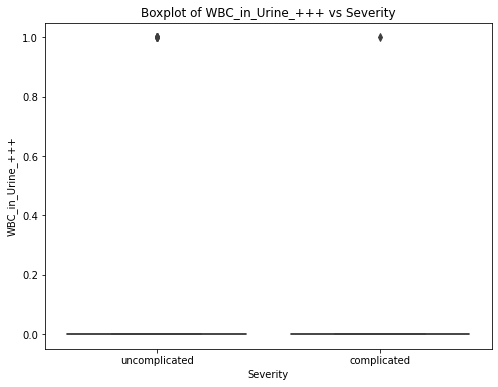

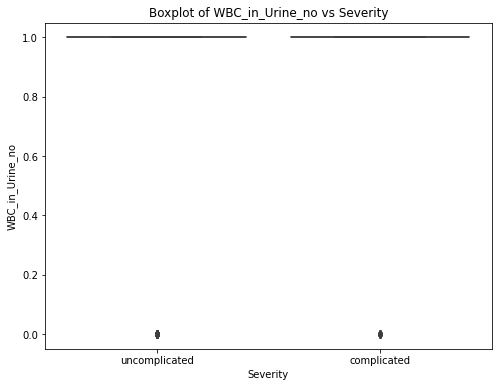

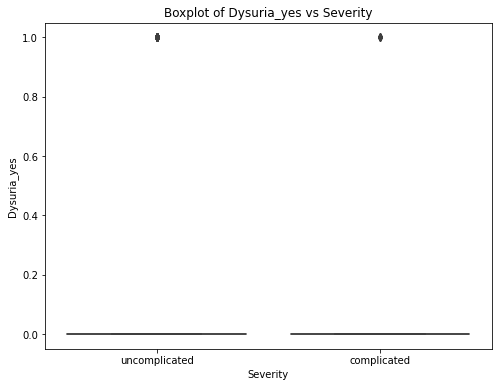

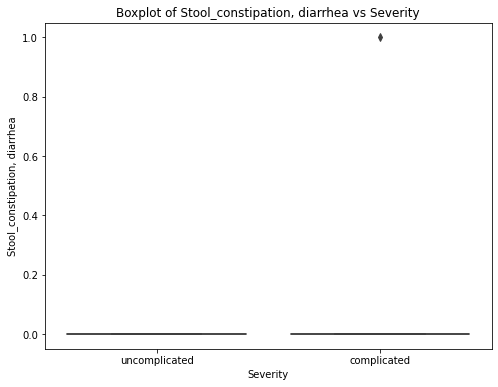

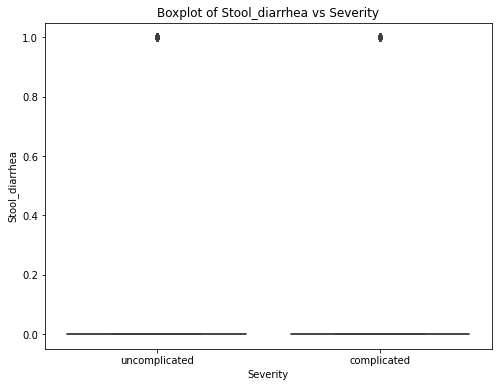

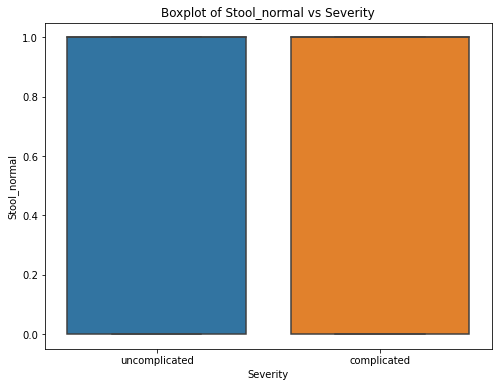

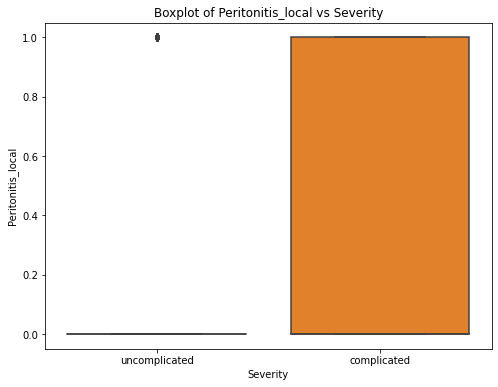

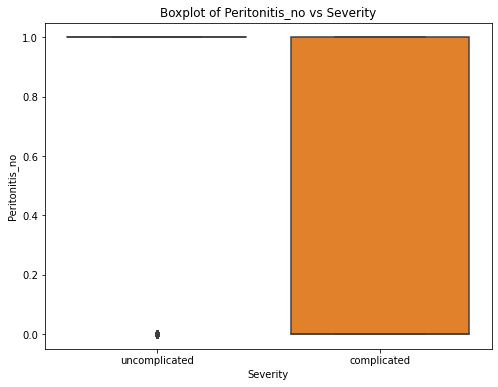

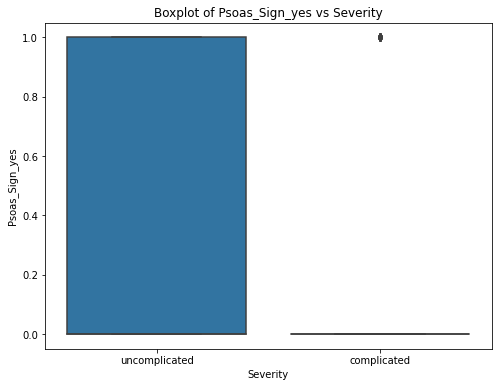

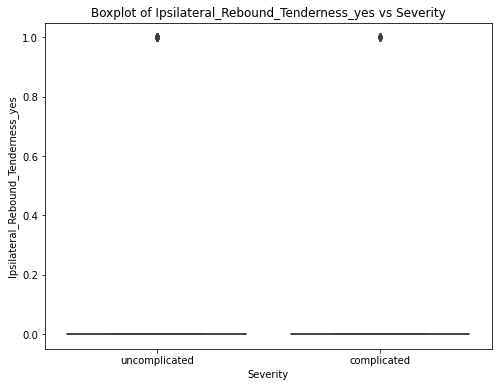

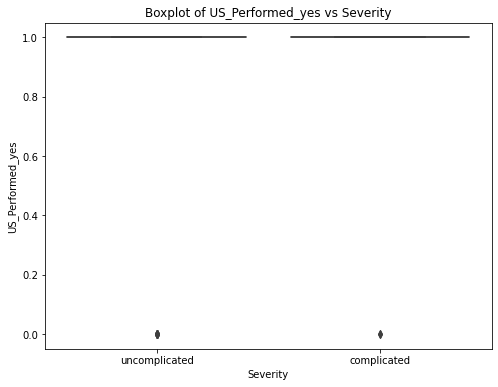

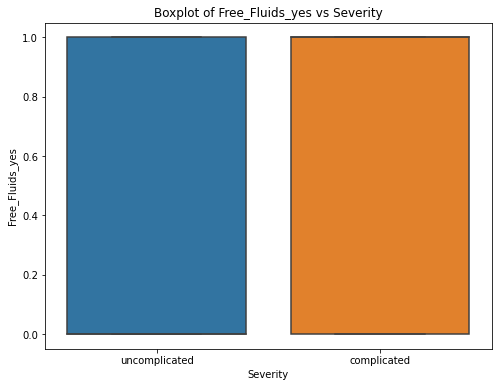

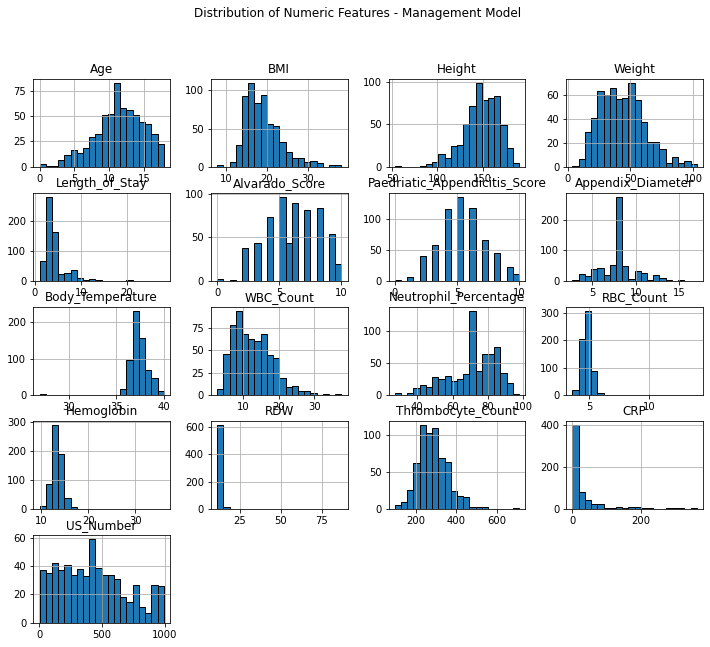

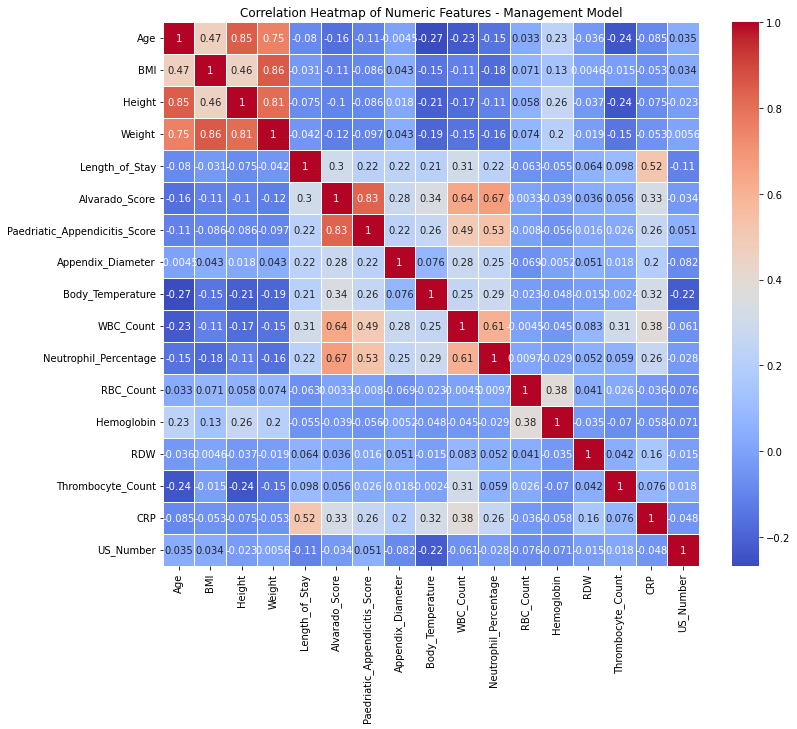

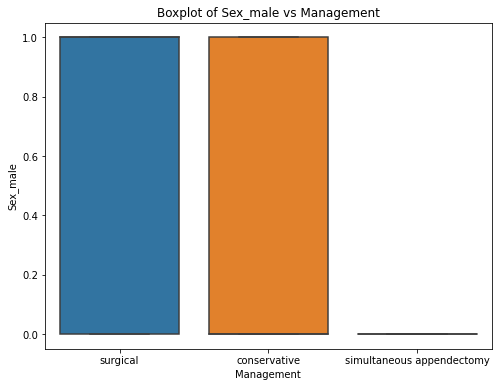

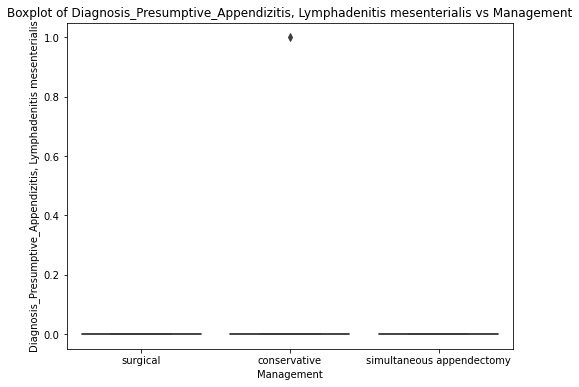

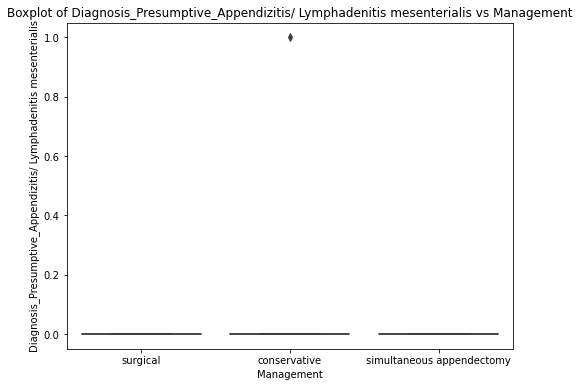

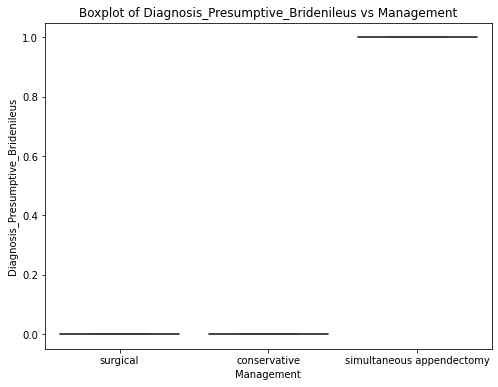

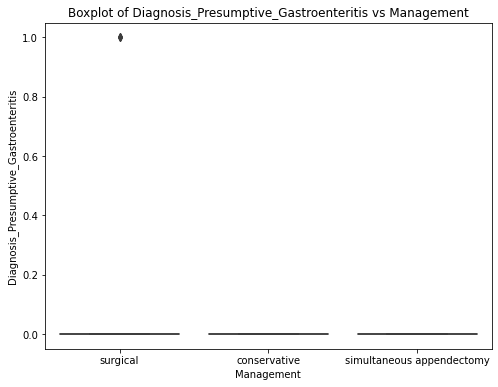

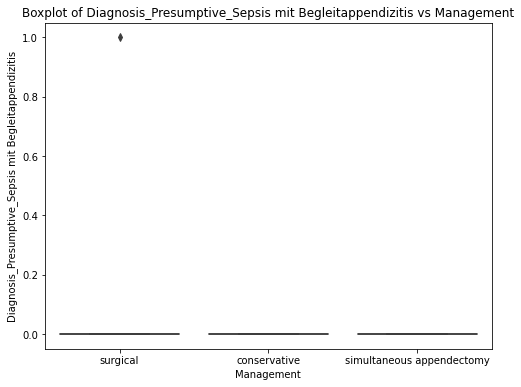

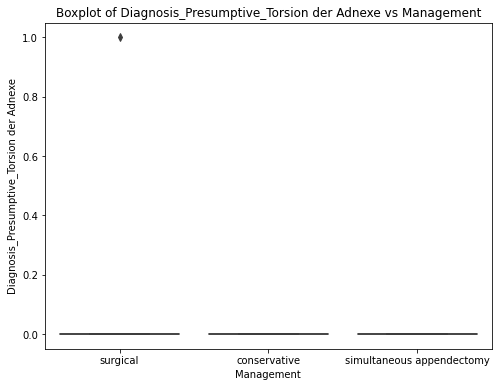

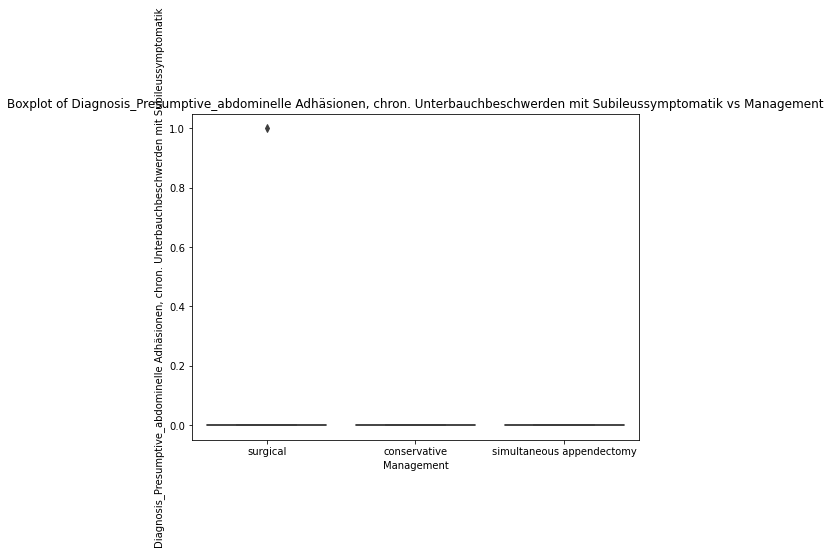

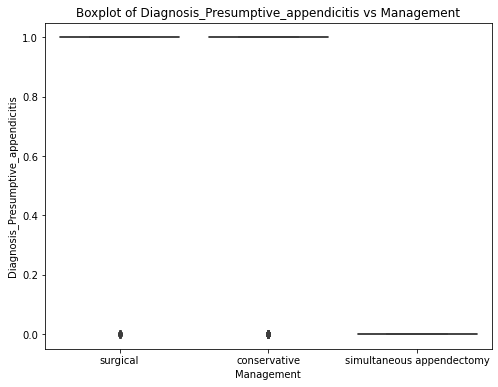

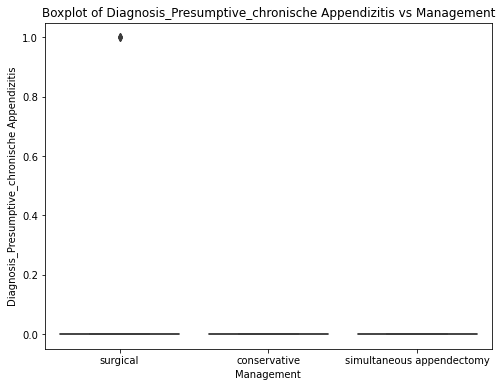

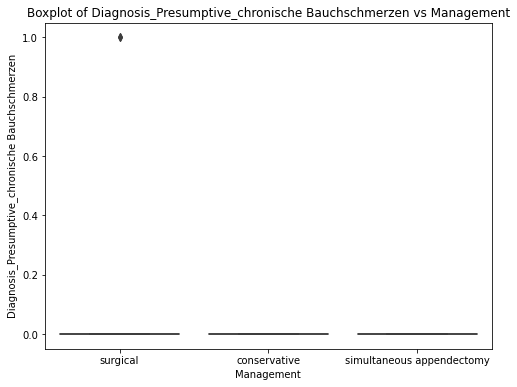

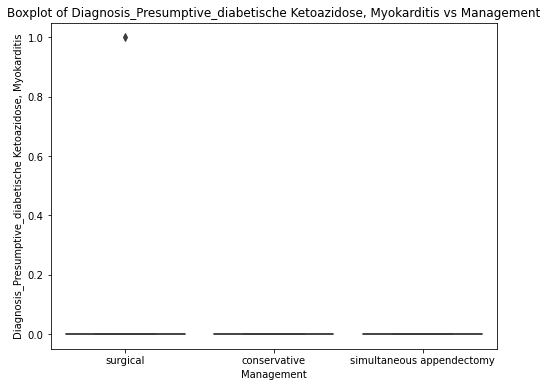

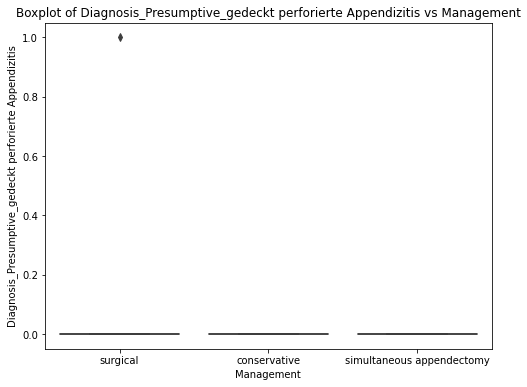

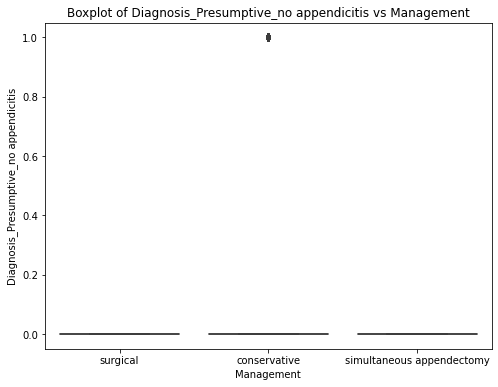

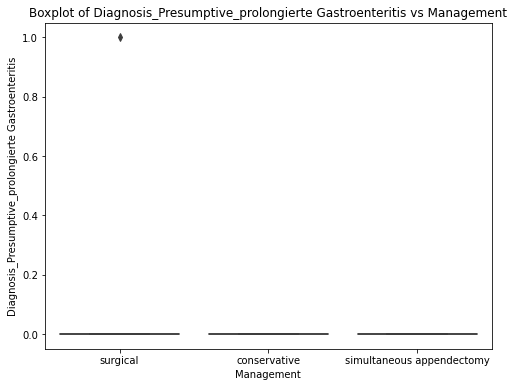

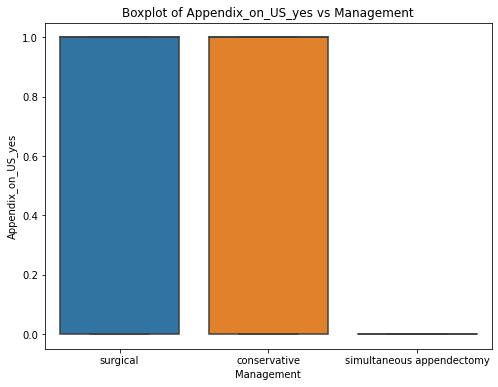

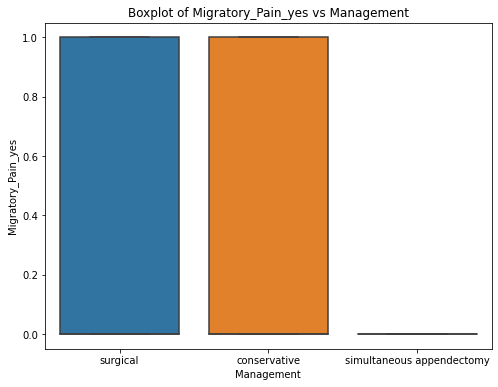

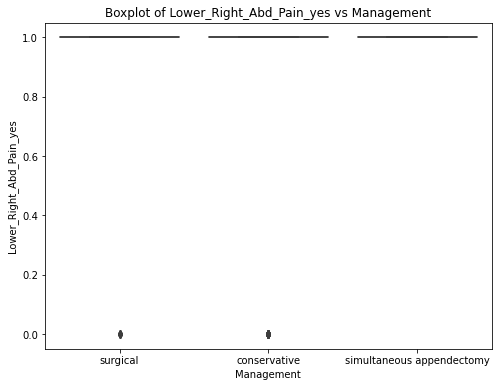

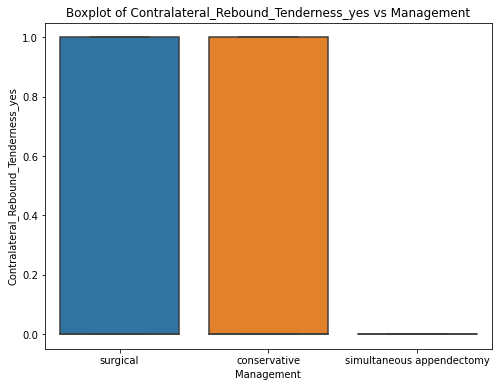

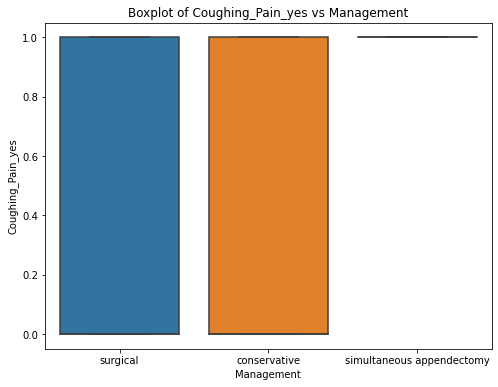

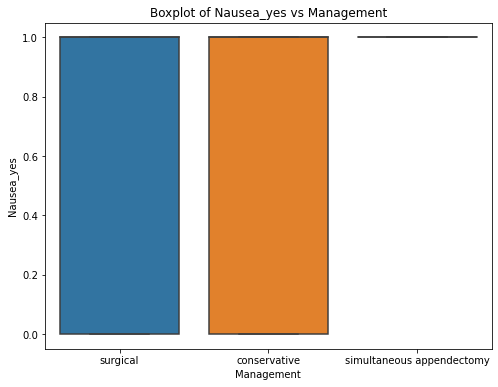

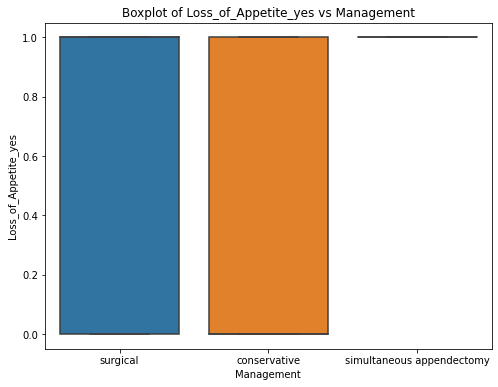

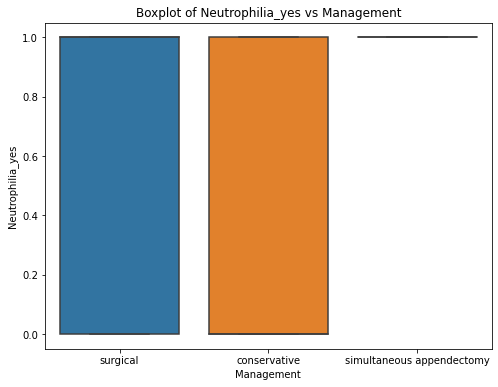

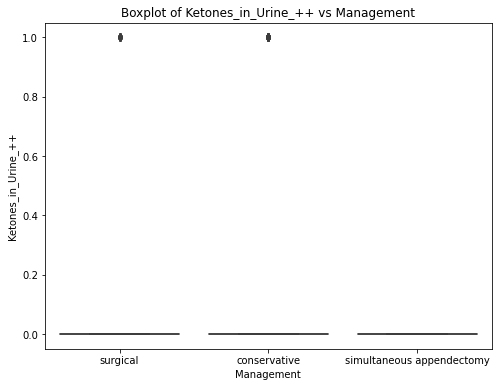

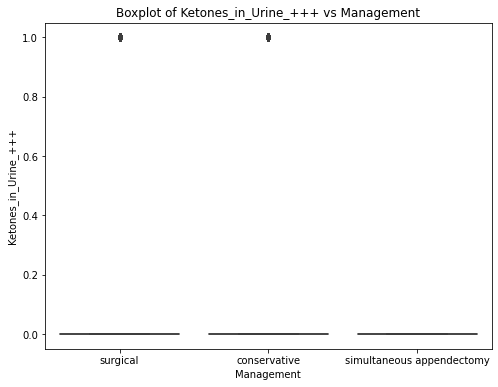

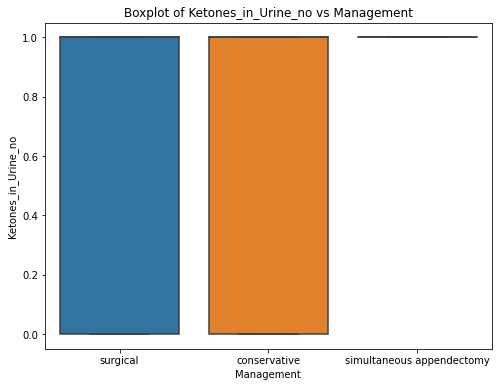

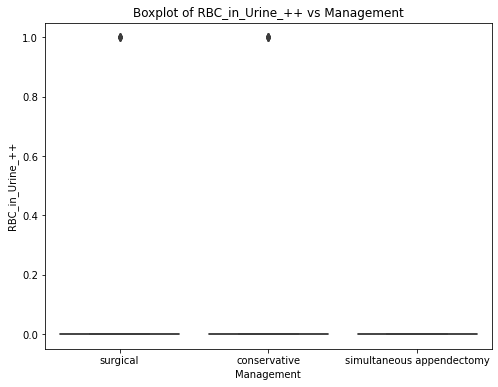

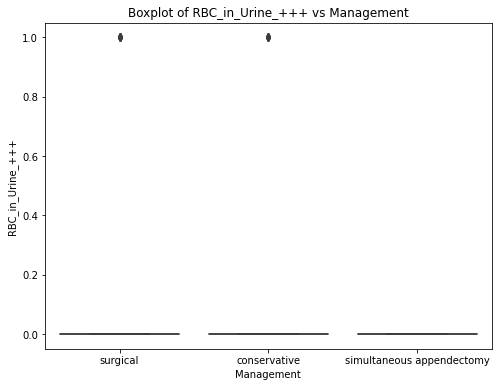

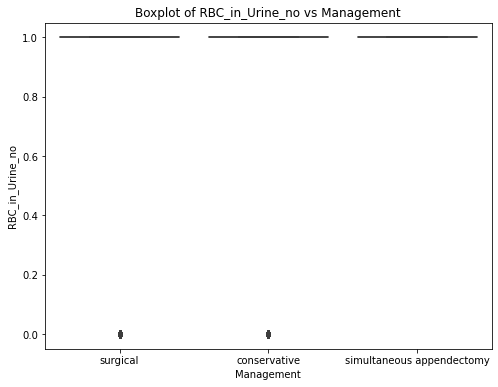

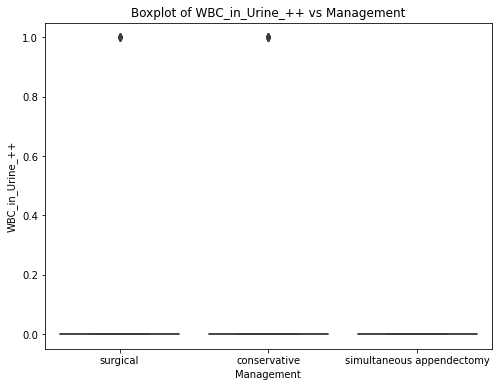

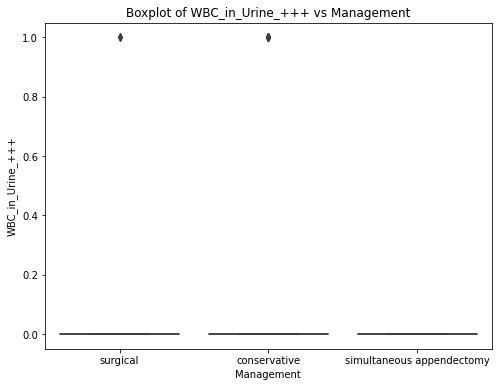

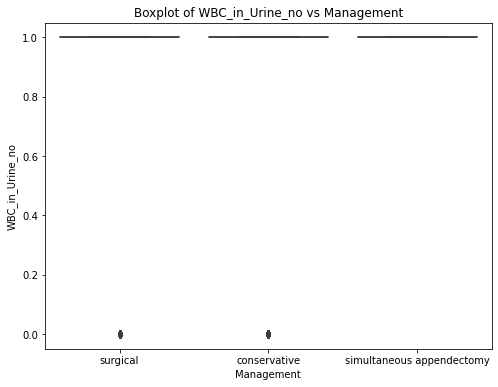

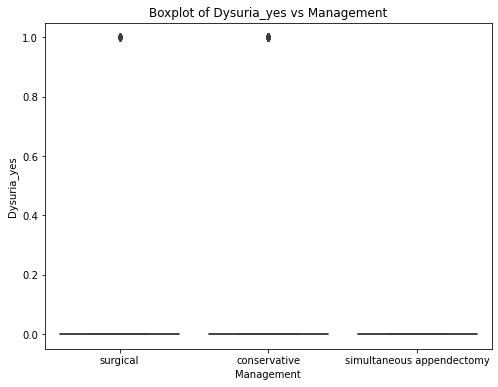

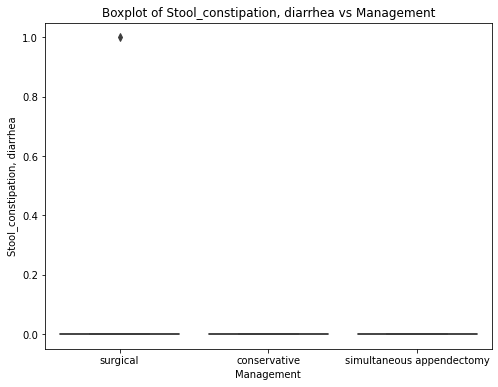

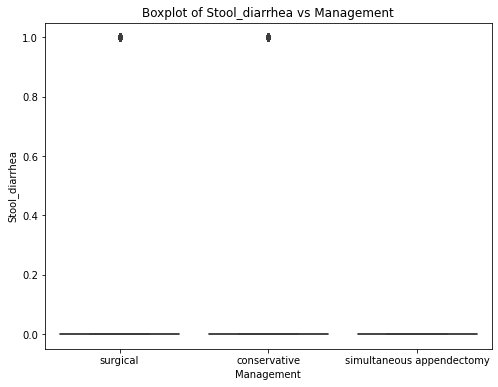

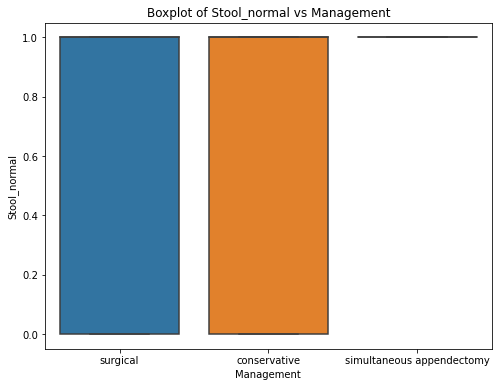

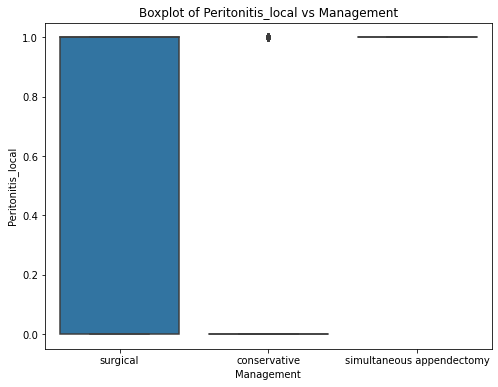

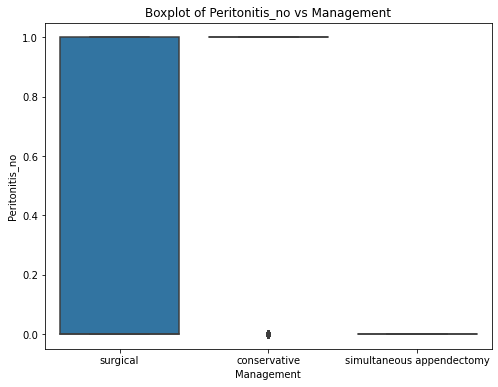

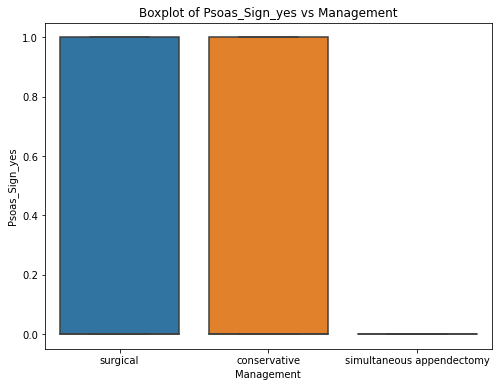

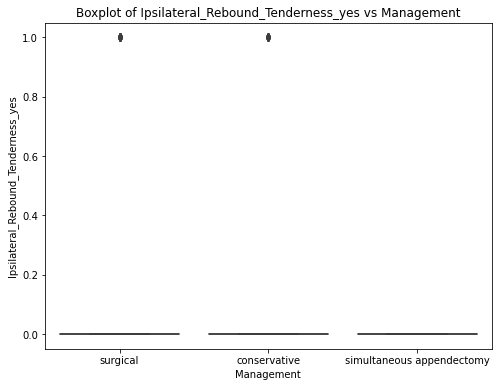

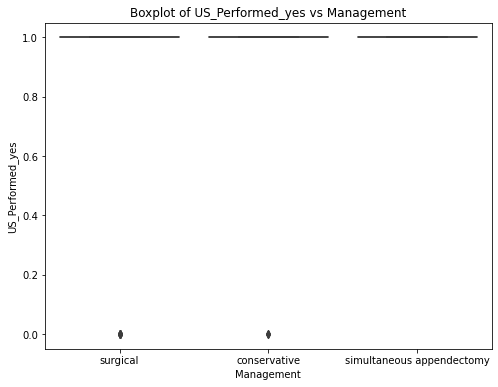

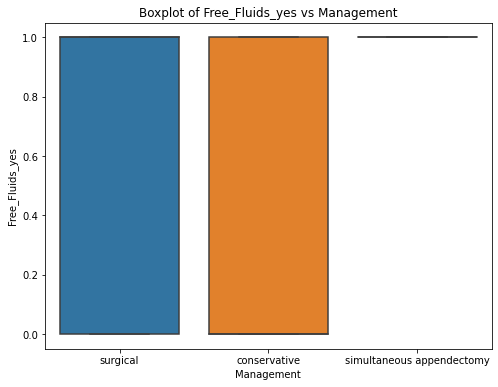

In [94]:
# ---------- EDA for Diagnosis Model ---------- #
# Numeric and categorical columns
numeric_cols_d = X_train_encoded_d.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_d = X_train_encoded_d.select_dtypes(include=['uint8']).columns

# Distribution plots for numeric features - Diagnosis Model
X_train_encoded_d[numeric_cols_d].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numeric Features - Diagnosis Model')
plt.show()

# Correlation heatmap for numeric features - Diagnosis Model
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_encoded_d[numeric_cols_d].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features - Diagnosis Model')
plt.show()

# Box plots for categorical features vs. Diagnosis target
for col in categorical_cols_d:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y_train_d, y=X_train_encoded_d[col])
    plt.title(f"Boxplot of {col} vs Diagnosis")
    plt.show()

# ---------- EDA for Severity Model ---------- #
# Numeric and categorical columns
numeric_cols_s = X_train_encoded_s.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_s = X_train_encoded_s.select_dtypes(include=['uint8']).columns

# Distribution plots for numeric features - Severity Model
X_train_encoded_s[numeric_cols_s].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numeric Features - Severity Model')
plt.show()

# Correlation heatmap for numeric features - Severity Model
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_encoded_s[numeric_cols_s].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features - Severity Model')
plt.show()

# Box plots for categorical features vs. Severity target
for col in categorical_cols_s:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y_train_s, y=X_train_encoded_s[col])
    plt.title(f"Boxplot of {col} vs Severity")
    plt.show()

# ---------- EDA for Management Model ---------- #
# Numeric and categorical columns
numeric_cols_m = X_train_encoded_m.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_m = X_train_encoded_m.select_dtypes(include=['uint8']).columns

# Distribution plots for numeric features - Management Model
X_train_encoded_m[numeric_cols_m].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numeric Features - Management Model')
plt.show()

# Correlation heatmap for numeric features - Management Model
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_encoded_m[numeric_cols_m].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features - Management Model')
plt.show()

# Box plots for categorical features vs. Management target
for col in categorical_cols_m:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y_train_m, y=X_train_encoded_m[col])
    plt.title(f"Boxplot of {col} vs Management")
    plt.show()

### EDA Insights Generation

We'll also generate detailed insights based on the Exploratory Data Analysis (EDA) for the **Diagnosis**, **Severity**, and **Management** models using the `generate_eda_insights` function that we will define. The function analyzes:

1. **Skewness of Numeric Features:**
   - Skewness is checked for each numeric feature, classifying it as highly skewed, moderately skewed, or symmetric based on its skewness value.
   
2. **Correlation Analysis:**
   - A correlation matrix is calculated for numeric features, and highly correlated pairs (correlation > 0.7) are identified.

3. **Boxplot Analysis for Categorical Features:**
   - The distribution of each categorical feature is evaluated, providing insights into how balanced the categories are.

This automated insight generation helps to quickly assess key patterns and relationships in the dataset.

In [96]:
# Function to generate text insights based on EDA
def generate_eda_insights(X_train, y_train, numeric_cols, categorical_cols, target_name):
    insights = []

    # Check for skewness in numeric columns
    insights.append(f"\nSkewness Analysis for {target_name} Model:")
    for col in numeric_cols:
        skewness = skew(X_train[col].dropna())  # Drop NaNs before computing skewness
        if abs(skewness) > 1:
            insights.append(f" - {col} is highly skewed with skewness: {skewness:.2f}")
        elif abs(skewness) > 0.5:
            insights.append(f" - {col} is moderately skewed with skewness: {skewness:.2f}")
        else:
            insights.append(f" - {col} is approximately symmetric with skewness: {skewness:.2f}")

    # Correlation analysis
    correlation_matrix = X_train[numeric_cols].corr()
    insights.append(f"\nCorrelation Analysis for {target_name} Model:")
    high_corr = correlation_matrix[correlation_matrix.abs() > 0.7].stack().index
    if high_corr.empty:
        insights.append(" - No numeric features are highly correlated.")
    else:
        for col_pair in high_corr:
            if col_pair[0] != col_pair[1]:
                insights.append(f" - {col_pair[0]} and {col_pair[1]} are highly correlated.")

    # Boxplot analysis for categorical columns
    insights.append(f"\nBoxplot Analysis for Categorical Features in {target_name} Model:")
    for col in categorical_cols:
        # Calculate the distribution between categories
        category_counts = X_train[col].value_counts()
        insights.append(f" - {col} has the following distribution: {category_counts.to_dict()}")
    
    return "\n".join(insights)


# ---------- EDA for Diagnosis Model ---------- #
print("\n--- Diagnosis Model EDA Insights ---\n")
eda_insights_diagnosis = generate_eda_insights(X_train_encoded_d, y_train_d, numeric_cols_d, categorical_cols_d, "Diagnosis")
print(eda_insights_diagnosis)

# ---------- EDA for Severity Model ---------- #
print("\n--- Severity Model EDA Insights ---\n")
eda_insights_severity = generate_eda_insights(X_train_encoded_s, y_train_s, numeric_cols_s, categorical_cols_s, "Severity")
print(eda_insights_severity)

# ---------- EDA for Management Model ---------- #
print("\n--- Management Model EDA Insights ---\n")
eda_insights_management = generate_eda_insights(X_train_encoded_m, y_train_m, numeric_cols_m, categorical_cols_m, "Management")
print(eda_insights_management)


--- Diagnosis Model EDA Insights ---


Skewness Analysis for Diagnosis Model:
 - Age is approximately symmetric with skewness: -0.44
 - BMI is highly skewed with skewness: 1.14
 - Height is moderately skewed with skewness: -0.73
 - Weight is moderately skewed with skewness: 0.54
 - Length_of_Stay is highly skewed with skewness: 3.37
 - Alvarado_Score is approximately symmetric with skewness: -0.12
 - Paedriatic_Appendicitis_Score is approximately symmetric with skewness: 0.19
 - Appendix_Diameter is moderately skewed with skewness: 0.60
 - Body_Temperature is highly skewed with skewness: -1.94
 - WBC_Count is moderately skewed with skewness: 0.77
 - Neutrophil_Percentage is moderately skewed with skewness: -0.71
 - RBC_Count is highly skewed with skewness: 9.05
 - Hemoglobin is highly skewed with skewness: 6.49
 - RDW is highly skewed with skewness: 16.60
 - Thrombocyte_Count is moderately skewed with skewness: 0.75
 - CRP is highly skewed with skewness: 3.02
 - US_Number is approxima

### Data Scaling and Balancing

We then apply scaling and class balancing techniques to prepare the data for model training. Here's a breakdown of the steps:

1. **Data Scaling:**
   - We use `StandardScaler` to scale the training and test data for each model (Diagnosis, Severity, and Management). This ensures that features are on a similar scale, which is essential for distance-based algorithms.

2. **Filtering Classes with Fewer than 2 Samples:**
   - Classes with fewer than 2 samples in the training data are removed to ensure reliable class balancing and prevent errors in the SMOTE algorithm.

3. **Class Balancing with SMOTE:**
   - **SMOTE (Synthetic Minority Over-sampling Technique)** is applied to the training data for each model to balance the class distribution. The number of neighbors for SMOTE (`k_neighbors`) is set based on the smallest class size to prevent overfitting.

This process ensures that the data is scaled and balanced, making it ready for robust model training.

In [97]:
# 1. Scaling the Data
scaler = StandardScaler()

# Scale the training and test data separately for each model
# Diagnosis Model
X_train_scaled_d = scaler.fit_transform(X_train_encoded_d)  # Fit on X_train
X_test_scaled_d = scaler.transform(X_test_encoded_d)  # Use the same scaler to transform X_test

# Severity Model
X_train_scaled_s = scaler.fit_transform(X_train_encoded_s)  # Fit on X_train
X_test_scaled_s = scaler.transform(X_test_encoded_s)  # Use the same scaler to transform X_test

# Management Model
X_train_scaled_m = scaler.fit_transform(X_train_encoded_m)  # Fit on X_train
X_test_scaled_m = scaler.transform(X_test_encoded_m)  # Use the same scaler to transform X_test

# 2. Further filtering classes with fewer than 2 samples
min_samples = 2

# Diagnosis Model
class_counts_d = y_train_d.value_counts()
y_train_d_filtered = y_train_d[y_train_d.isin(class_counts_d[class_counts_d >= min_samples].index)]
X_train_scaled_d_filtered = X_train_scaled_d[y_train_d.isin(class_counts_d[class_counts_d >= min_samples].index)]

# Severity Model
class_counts_s = y_train_s.value_counts()
y_train_s_filtered = y_train_s[y_train_s.isin(class_counts_s[class_counts_s >= min_samples].index)]
X_train_scaled_s_filtered = X_train_scaled_s[y_train_s.isin(class_counts_s[class_counts_s >= min_samples].index)]

# Management Model
class_counts_m = y_train_m.value_counts()
y_train_m_filtered = y_train_m[y_train_m.isin(class_counts_m[class_counts_m >= min_samples].index)]
X_train_scaled_m_filtered = X_train_scaled_m[y_train_m.isin(class_counts_m[class_counts_m >= min_samples].index)]

# Check the number of samples in the smallest class and set k_neighbors accordingly
# Diagnosis Model
k_neighbors_d = min(class_counts_d[class_counts_d >= min_samples].min() - 1, 5)  # Ensure k_neighbors <= samples
smote_d = SMOTE(random_state=42, k_neighbors=k_neighbors_d)

# Severity Model
k_neighbors_s = min(class_counts_s[class_counts_s >= min_samples].min() - 1, 5)
smote_s = SMOTE(random_state=42, k_neighbors=k_neighbors_s)

# Management Model
k_neighbors_m = min(class_counts_m[class_counts_m >= min_samples].min() - 1, 5)
smote_m = SMOTE(random_state=42, k_neighbors=k_neighbors_m)

# 3. Applying SMOTE to filtered data
X_train_balanced_d, y_train_balanced_d = smote_d.fit_resample(X_train_scaled_d_filtered, y_train_d_filtered)
X_train_balanced_s, y_train_balanced_s = smote_s.fit_resample(X_train_scaled_s_filtered, y_train_s_filtered)
X_train_balanced_m, y_train_balanced_m = smote_m.fit_resample(X_train_scaled_m_filtered, y_train_m_filtered)


### Feature Selection Based on EDA Insights

We then perform feature selection for the **Diagnosis**, **Severity**, and **Management** models using insights from the Exploratory Data Analysis (EDA). The `select_features_after_eda` function is used to select the most relevant features based on the following criteria:

1. **Numeric Feature Selection:**
   - Features are selected based on clinical importance, skewness, and correlation analysis.
   - Highly skewed features are retained only if they are clinically significant (e.g., CRP, WBC Count).
   - From pairs of highly correlated features, only the more clinically relevant feature is retained.

2. **Categorical Feature Selection:**
   - Clinically important categorical features are selected based on their significance to the model (e.g., Sex, Appendix on US, Lower Right Abdomen Pain).
   - Each model (Diagnosis, Severity, Management) selects additional categorical features relevant to its target based on clinical importance (e.g., Migratory Pain for Diagnosis, Free Fluids for Severity, etc.).

This approach ensures that the selected features are both clinically meaningful and free from redundancy due to high correlation.

In [98]:
def select_features_after_eda(target_model, numeric_cols, categorical_cols, correlation_info, skew_info):
    selected_features = []

    # Select numeric features based on clinical importance, skewness, and correlation analysis
    for col in numeric_cols:
        if skew_info[col] < 2 or col in ['CRP', 'WBC_Count']:  # Retain important but skewed clinical variables
            if col not in correlation_info:  # Retain if no high correlation, or prefer clinically important one
                selected_features.append(col)
            else:
                # Retain one from the correlated pair based on importance (e.g., Alvarado_Score > Paedriatic_Appendicitis_Score)
                if correlation_info[col] in selected_features:  
                    continue
                else:
                    selected_features.append(col)

    # Select categorical features based on clinical importance and boxplot distribution
    for col in categorical_cols:
        if col in ['Sex_male', 'Appendix_on_US_yes', 'Lower_Right_Abd_Pain_yes']:  # Clinically significant
            selected_features.append(col)

        # Model-specific feature selection
        if target_model == 'Diagnosis' and col in ['Migratory_Pain_yes', 'Neutrophilia_yes', 'Coughing_Pain_yes']:
            selected_features.append(col)

        if target_model == 'Severity' and col in ['Free_Fluids_yes', 'Peritonitis_local', 'Neutrophilia_yes']:
            selected_features.append(col)

        if target_model == 'Management' and col in ['Free_Fluids_yes', 'Peritonitis_local', 'Ipsilateral_Rebound_Tenderness_yes']:
            selected_features.append(col)

    return selected_features

# Define correlation information from EDA insights
correlation_info = {
    'Age': ['Height', 'Weight'],  # Highly correlated with both Height and Weight
    'Weight': ['BMI'],  # Highly correlated with BMI
    'Alvarado_Score': ['Paedriatic_Appendicitis_Score']  # Highly correlated with Paedriatic_Appendicitis_Score
}

# Define skewness from EDA insights
skew_info = {
    'Age': -0.44, 'BMI': 1.14, 'Height': -0.73, 'Weight': 0.54, 'Length_of_Stay': 3.37,
    'Alvarado_Score': -0.12, 'Paedriatic_Appendicitis_Score': 0.19, 'Appendix_Diameter': 0.60,
    'Body_Temperature': -1.94, 'WBC_Count': 0.77, 'Neutrophil_Percentage': -0.71,
    'RBC_Count': 9.05, 'Hemoglobin': 6.49, 'RDW': 16.60, 'Thrombocyte_Count': 0.75, 'CRP': 3.02, 'US_Number': 0.38
}

# Common numeric and categorical columns identified in the dataset
numeric_cols_common = ['Age', 'BMI', 'Length_of_Stay', 'Alvarado_Score', 'Body_Temperature', 'WBC_Count', 'CRP']
categorical_cols_common = ['Sex_male', 'Appendix_on_US_yes', 'Lower_Right_Abd_Pain_yes', 'Migratory_Pain_yes', 
                           'Neutrophilia_yes', 'Nausea_yes', 'Free_Fluids_yes', 'Peritonitis_local', 
                           'Ipsilateral_Rebound_Tenderness_yes']

# ----- Feature Selection for Diagnosis Model -----
selected_features_diagnosis = select_features_after_eda('Diagnosis', numeric_cols_common, categorical_cols_common, correlation_info, skew_info)

# ----- Feature Selection for Severity Model -----
selected_features_severity = select_features_after_eda('Severity', numeric_cols_common, categorical_cols_common, correlation_info, skew_info)

# ----- Feature Selection for Management Model -----
selected_features_management = select_features_after_eda('Management', numeric_cols_common, categorical_cols_common, correlation_info, skew_info)

# Display selected features for each model
print("Selected Features for Diagnosis Model:", selected_features_diagnosis)
print("Selected Features for Severity Model:", selected_features_severity)
print("Selected Features for Management Model:", selected_features_management)


Selected Features for Diagnosis Model: ['Age', 'BMI', 'Alvarado_Score', 'Body_Temperature', 'WBC_Count', 'CRP', 'Sex_male', 'Appendix_on_US_yes', 'Lower_Right_Abd_Pain_yes', 'Migratory_Pain_yes', 'Neutrophilia_yes']
Selected Features for Severity Model: ['Age', 'BMI', 'Alvarado_Score', 'Body_Temperature', 'WBC_Count', 'CRP', 'Sex_male', 'Appendix_on_US_yes', 'Lower_Right_Abd_Pain_yes', 'Neutrophilia_yes', 'Free_Fluids_yes', 'Peritonitis_local']
Selected Features for Management Model: ['Age', 'BMI', 'Alvarado_Score', 'Body_Temperature', 'WBC_Count', 'CRP', 'Sex_male', 'Appendix_on_US_yes', 'Lower_Right_Abd_Pain_yes', 'Free_Fluids_yes', 'Peritonitis_local', 'Ipsilateral_Rebound_Tenderness_yes']


### Model Building and Evaluation

### Label Encoding for Target Variables

Now, we encode the target variables for the **Diagnosis**, **Severity**, and **Management** models using the `encode_labels` function. This encoding is necessary to convert the categorical target labels into numerical values for model training. Here's how it's done:

1. **Diagnosis Model:**
   - **Binary Classification** where `0` represents "no appendicitis" and `1` represents "appendicitis."

2. **Severity Model:**
   - **Binary Classification** where `0` represents "uncomplicated" and `1` represents "complicated."

3. **Management Model:**
   - **Multiclass Classification** where `0` represents "conservative," `1` represents "primary surgical," and `2` represents "secondary surgical."

This encoding prepares the target variables for training in classification models.

### Model Building for Classification

We would now build three machine learning models—**Logistic Regression**, **Random Forest**, and **XGBoost**—for each of the target variables (**Diagnosis**, **Severity**, and **Management**) using the `build_models` function. Here's the process:

1. **Encoding Target Labels:**
   - The target labels are first encoded into numeric values using the `encode_labels` function to prepare them for model training.

2. **Model Selection:**
   - **Logistic Regression:** A linear model commonly used for binary classification.
   - **Random Forest:** A powerful ensemble model that builds multiple decision trees.
   - **XGBoost:** A high-performance boosting algorithm suited for both binary and multiclass classification.

3. **Training the Models:**
   - Each model is trained on the balanced training data using the `fit()` method.

The function returns the trained models, which are now ready for evaluation on the test sets.

In [99]:
# Function to encode labels for each target
def encode_labels(target, target_name):
    if target_name == "Diagnosis":
        return target.map({'no appendicitis': 0, 'appendicitis': 1})  # Binary classification
    elif target_name == "Severity":
        return target.map({'uncomplicated': 0, 'complicated': 1})  # Binary classification
    elif target_name == "Management":
        return target.map({'conservative': 0, 'surgical': 1})  # Binary classification
    else:
        raise ValueError("Unknown target name")

        
# Function to build models
def build_models(X_train, y_train, target_name):
    # Encode y_train labels to numeric
    y_train_encoded = encode_labels(y_train, target_name)
    
    # 1. Logistic Regression
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train, y_train_encoded)
    
    # 2. Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train_encoded)
    
    # 3. XGBoost
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train, y_train_encoded)
    
    # Return the trained models
    return log_reg, rf, xgb, y_train_encoded

# Building models for Diagnosis
log_reg_d, rf_d, xgb_d, y_train_encoded_d = build_models(X_train_balanced_d, y_train_balanced_d, "Diagnosis")

# Similarly, build for Severity and Management
log_reg_s, rf_s, xgb_s, y_train_encoded_s = build_models(X_train_balanced_s, y_train_balanced_s, "Severity")
log_reg_m, rf_m, xgb_m, y_train_encoded_m = build_models(X_train_balanced_m, y_train_balanced_m, "Management")


### Model Evaluation

In this cell, we evaluate the performance of each model (Logistic Regression, Random Forest, and XGBoost) for the **Diagnosis**, **Severity**, and **Management** targets using the `evaluate_model` function. The steps involved are:

1. **Encoding Test Labels:** The test labels are first encoded into numeric values using the `encode_labels` function.
2. **Predictions and Probabilities:** The models make predictions on the test data, and for binary classification (Diagnosis and Severity), we also extract the predicted probabilities for the ROC-AUC curve.
3. **Classification Report:** A detailed report of precision, recall, F1-score, and accuracy is generated to evaluate the model's performance.
4. **Confusion Matrix:** A confusion matrix is displayed to show the number of correct and incorrect predictions.
5. **ROC-AUC Curve (Binary Classification):** For binary classification, we plot the Receiver Operating Characteristic (ROC) curve to evaluate the model's ability to distinguish between classes.

Classification Report for Diagnosis:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        62
           1       0.91      0.86      0.89        95

    accuracy                           0.87       157
   macro avg       0.86      0.87      0.86       157
weighted avg       0.87      0.87      0.87       157

Confusion Matrix for Diagnosis:
 [[54  8]
 [13 82]]


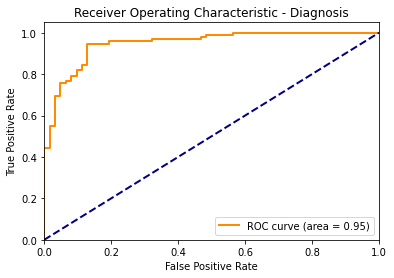

Classification Report for Severity:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       133
           1       0.69      0.83      0.75        24

    accuracy                           0.92       157
   macro avg       0.83      0.88      0.85       157
weighted avg       0.93      0.92      0.92       157

Confusion Matrix for Severity:
 [[124   9]
 [  4  20]]


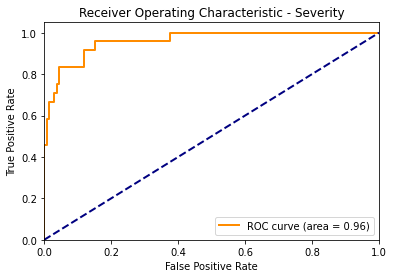

Classification Report for Management:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        97
           1       0.92      0.92      0.92        60

    accuracy                           0.94       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.94      0.94      0.94       157

Confusion Matrix for Management:
 [[92  5]
 [ 5 55]]


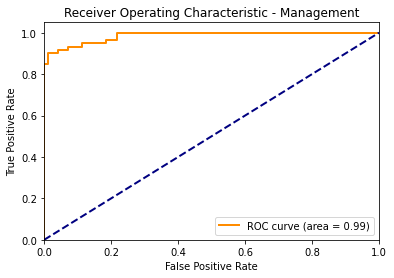

In [101]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, target_name):
    y_test_encoded = encode_labels(y_test, target_name)
    
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    
    # For binary classification (ROC-AUC), we only want the probabilities for class 1
    if target_name in ["Diagnosis", "Severity", "Management"]:
        y_prob = model.predict_proba(X_test)[:, 1]  # For ROC-AUC curve
    
    # Classification Report
    print(f"Classification Report for {target_name}:")
    print(classification_report(y_test_encoded, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    print(f"Confusion Matrix for {target_name}:\n", cm)
    
    # ROC-AUC curve (only for binary classification)
    if target_name in ["Diagnosis", "Severity", "Management"]:
        fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
        roc_auc = auc(fpr, tpr)
    
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {target_name}')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"ROC-AUC curve not available for {target_name} as it is a multiclass classification.")

# Evaluate Logistic Regression
evaluate_model(log_reg_d, X_test_scaled_d, y_test_d, "Diagnosis")
evaluate_model(log_reg_s, X_test_scaled_s, y_test_s, "Severity")
evaluate_model(log_reg_m, X_test_scaled_m, y_test_m, "Management")

### Model Evaluation for Random Forest and XGBoost

Following the previous evaluation steps, we now assess the **Random Forest** and **XGBoost** models for the **Diagnosis**, **Severity**, and **Management** targets. We generate the classification report, confusion matrix, and ROC-AUC for both models.

Classification Report for Diagnosis:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        62
           1       0.88      0.89      0.89        95

    accuracy                           0.86       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.86      0.86      0.86       157

Confusion Matrix for Diagnosis:
 [[50 12]
 [10 85]]


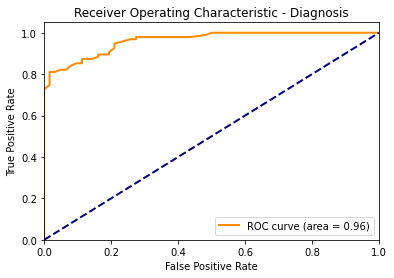

Classification Report for Severity:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       133
           1       0.74      0.71      0.72        24

    accuracy                           0.92       157
   macro avg       0.84      0.83      0.84       157
weighted avg       0.92      0.92      0.92       157

Confusion Matrix for Severity:
 [[127   6]
 [  7  17]]


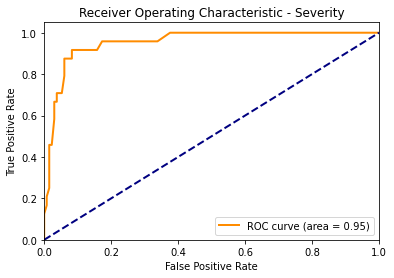

Classification Report for Management:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        97
           1       0.92      0.95      0.93        60

    accuracy                           0.95       157
   macro avg       0.94      0.95      0.95       157
weighted avg       0.95      0.95      0.95       157

Confusion Matrix for Management:
 [[92  5]
 [ 3 57]]


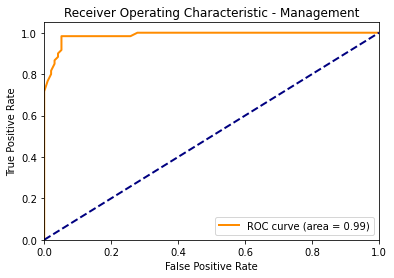

Classification Report for Diagnosis:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        62
           1       0.95      0.96      0.95        95

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157

Confusion Matrix for Diagnosis:
 [[57  5]
 [ 4 91]]


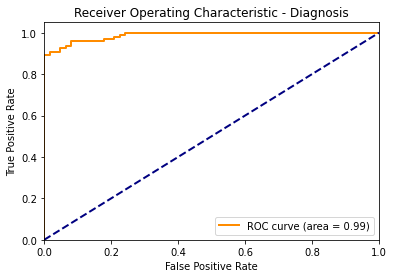

Classification Report for Severity:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       133
           1       0.75      0.88      0.81        24

    accuracy                           0.94       157
   macro avg       0.86      0.91      0.88       157
weighted avg       0.94      0.94      0.94       157

Confusion Matrix for Severity:
 [[126   7]
 [  3  21]]


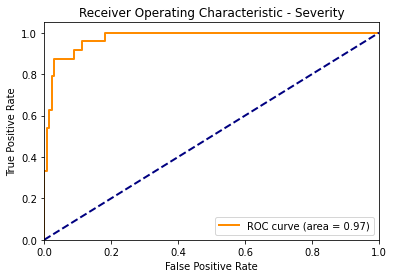

Classification Report for Management:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        97
           1       0.95      0.95      0.95        60

    accuracy                           0.96       157
   macro avg       0.96      0.96      0.96       157
weighted avg       0.96      0.96      0.96       157

Confusion Matrix for Management:
 [[94  3]
 [ 3 57]]


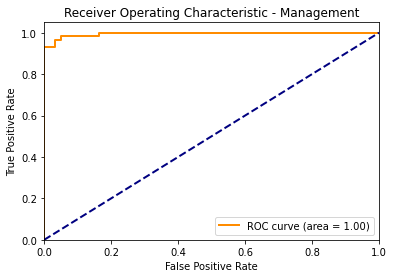

In [102]:
# Evaluate Random Forest for Diagnosis
evaluate_model(rf_d, X_test_scaled_d, y_test_d, "Diagnosis")

# Similarly for Severity and Management
evaluate_model(rf_s, X_test_scaled_s, y_test_s, "Severity")
evaluate_model(rf_m, X_test_scaled_m, y_test_m, "Management")

# Evaluate XGBoost for Diagnosis
evaluate_model(xgb_d, X_test_scaled_d, y_test_d, "Diagnosis")

# Similarly for Severity and Management
evaluate_model(xgb_s, X_test_scaled_s, y_test_s, "Severity")
evaluate_model(xgb_m, X_test_scaled_m, y_test_m, "Management")

### Model Building and Evaluation

For this project, we employed three algorithms—**Logistic Regression**, **Random Forest**, and **XGBoost**—to predict the following targets: 
1. **Diagnosis**: Appendicitis vs. No Appendicitis
2. **Severity**: Complicated vs. Uncomplicated
3. **Management**: Surgical vs. Conservative

#### 1. **Diagnosis Classification**
- **Logistic Regression**: Achieved an accuracy of 87% with a balanced precision (0.81) and recall (0.87). However, it produced some false positives and negatives, impacting overall reliability.
- **Random Forest**: Similar performance to Logistic Regression with 86% accuracy, highlighting moderate improvement in correctly identifying appendicitis cases.
- **XGBoost**: Outperformed the others with 94% accuracy, showing a high precision (0.93) and recall (0.92), resulting in fewer misclassifications.
- **Conclusion**: XGBoost is the best model for diagnosis due to its high accuracy and balanced precision-recall, making it an excellent support tool for identifying appendicitis.

#### 2. **Severity Classification**
- **Logistic Regression**: Reached 92% accuracy, showing high precision (0.97) for uncomplicated cases but struggled with complicated ones (precision 0.69).
- **Random Forest**: Also achieved 92% accuracy with a slight improvement in recall for complicated cases.
- **XGBoost**: Performed best with an accuracy of 94% and a higher recall for complicated cases, reducing false negatives.
- **Conclusion**: XGBoost provides a more reliable prediction of severity, especially for complicated cases, offering better support in clinical decision-making.

#### 3. **Management Classification**
- **Logistic Regression**: Provided 94% accuracy, with balanced precision and recall for both conservative and surgical cases.
- **Random Forest**: Slight improvement with 95% accuracy, but still had a few misclassifications.
- **XGBoost**: Achieved the highest accuracy of 96%, minimizing false positives and false negatives.
- **Conclusion**: XGBoost is the most dependable for management predictions due to its highest accuracy and reduced error rate, enhancing treatment decisions.

### Performance Summary
- **XGBoost** consistently delivered the best results across all three targets with the highest accuracy and balanced precision-recall, making it the most reliable model for clinical decision support.
- Classification reports and confusion matrices indicate that XGBoost minimizes misclassifications and captures relevant clinical patterns, which is crucial for effective diagnosis and treatment planning.
- **AUC-ROC Curves** (for Diagnosis and Severity) show that XGBoost has an excellent ability to distinguish between classes, further solidifying its role in aiding clinical decisions.

### Clinical Insight
By leveraging the strengths of XGBoost, healthcare professionals can make more informed decisions with a reliable model that balances accuracy, precision, and recall, thereby improving patient outcomes.

In [103]:
import pickle

# Assuming 'xgb_d' is the trained XGBoost model for diagnosis
model_filename = 'xgboost_diagnosis_model.pkl'

# Save the model using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_d, file)

print(f"Model saved as {model_filename}")

Model saved as xgboost_diagnosis_model.pkl
